In [6]:
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LogNorm
from astropy.coordinates import SkyCoord
import astropy.constants as const

import numpy as np
import pandas as pd
import gala.dynamics as gd
import gala.units as gu

import kicker

In [2]:
pd.set_option('display.max_columns', None)

In [9]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
plt.style.use('dark_background')

In [112]:
p = kicker.pop.load("data/recent-pop")

# Stellar type labels and colours

In [13]:
stellar_types = [
    None,
    {"long": "Main Sequence", "short": "MS", "colour": None},
    {"long": "Hertzsprung Gap", "short": "HG", "colour": None},
    {"long": "First Giant Branch", "short": "FGB", "colour": None},
    {"long": "Core Helium Burning", "short": "CHeB", "colour": None},
    {"long": "Early Asymptotic Giant Branch", "short": "EAGB", "colour": None},
    {"long": "Thermally Pulsing Asymptotic Giant Branch", "short": "TPAGB", "colour": None},
    {"long": "Helium Main Sequence", "short": "HeMS", "colour": None},
    {"long": "Helium Hertsprung Gap", "short": "HeHG", "colour": None},
    {"long": "Helium Giant Branch", "short": "HeGB", "colour": None},
    {"long": "Helium White Dwarf", "short": "HeWD", "colour": None},
    {"long": "Carbon/Oxygen White Dwarf", "short": "COWD", "colour": None},
    {"long": "Oxygen/Neon White Dwarf", "short": "ONeWD", "colour": None},
    {"long": "Neutron Star", "short": "NS", "colour": "grey"},
    {"long": "Black Hole", "short": "BH", "colour": "black"},
    {"long": "Massless Remnant", "short": "MR", "colour": "yellow"},
    {"long": "Chemically Homogeneous", "short": "CHE", "colour": "brown"}
]

for i in [1, 2]:
    stellar_types[i]["colour"] = plt.get_cmap("YlOrBr")(0.3 * i)

for i in [3, 4]:
    stellar_types[i]["colour"] = plt.get_cmap("Blues")(0.3 * (i - 2))

for i in [5, 6]:
    stellar_types[i]["colour"] = plt.get_cmap("Greens")(0.3 * (3 - (i - 4)))

for i in [7, 8, 9]:
    stellar_types[i]["colour"] = plt.get_cmap("plasma")(0.1 + 0.2 * (i - 7))

for i in [10, 11, 12]:
    stellar_types[i]["colour"] = plt.get_cmap("copper")(0.1 + 0.2 * (i - 9))

# Magnitude plots

In [17]:
def get_mag_combined(filter, mag_type):
    return np.concatenate((p.observables[f"{filter}_{mag_type}_1"][shiny],
                           p.observables[f"{filter}_{mag_type}_2"][shiny & disrupted]))

In [29]:
shiny = ~p.final_bpp["kstar_1"].isin([14, 15])
disrupted = p.final_bpp["sep"] < 0.0

distances = np.concatenate((p.final_coords[0][shiny].icrs.distance, p.final_coords[1][shiny & disrupted].icrs.distance))
G_abs = get_mag_combined("G", "abs")
G_BP_app = get_mag_combined("BP", "app")
G_RP_app = get_mag_combined("RP", "app")
mass = np.concatenate((np.where(p.observables["secondary_brighter"],
                       p.final_bpp["mass_2"],
                       p.final_bpp["mass_1"])[shiny], p.final_bpp["mass_2"][shiny & disrupted]))
lum = np.concatenate((np.where(p.observables["secondary_brighter"],
                      p.final_bpp["lum_2"],
                      p.final_bpp["lum_1"])[shiny], p.final_bpp["lum_2"][shiny & disrupted]))
kstar = np.concatenate((np.where(p.observables["secondary_brighter"],
                        p.final_bpp["kstar_2"],
                        p.final_bpp["kstar_1"])[shiny], p.final_bpp["kstar_2"][shiny & disrupted])).astype(int)

kstar[kstar == 0] = 1
unique_kstars = np.unique(kstar)

## Gaia CMD

### By stellar type

In [47]:
import gala.potential as gp

In [55]:
import astropy.coordinates as coords

In [64]:
p = kicker.pop.Population(10, m1_cutoff=0)
p.sample_initial_binaries()

In [65]:
# turn the drawn coordinates into an astropy representation
rep = coords.CylindricalRepresentation(p.initial_galaxy.rho,
                                       p.initial_galaxy.phi,
                                       p.initial_galaxy.z)

# create differentials based on the velocities (dimensionless angles allows radians conversion)
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    dif = coords.CylindricalDifferential(p.initial_galaxy.v_R,
                                         (p.initial_galaxy.v_T
                                          / p.initial_galaxy.rho).to(u.rad / u.Gyr),
                                         p.initial_galaxy.v_z)

# combine the representation and differentials into a Gala PhaseSpacePosition
w0s = gd.PhaseSpacePosition(rep.with_differentials(dif))

In [75]:
import gala.integrate as gi

In [83]:
w = p.galactic_potential.integrate_orbit(w0=w0s[0], Integrator=gi.DOPRI853Integrator, t1=0 * u.Myr, t2=200 * u.Myr, dt=1 * u.Myr)

In [103]:
w[-1].x

<Quantity -5.32066452 kpc>

In [102]:
w[-1:][-1].x

<Quantity -5.32066452 kpc>

In [96]:
w[:, None]

<Orbit cartesian, dim=3, shape=(200, 1)>

In [66]:
w0s

<PhaseSpacePosition cylindrical, dim=3, shape=(16,)>

In [ ]:
p.fina


In [53]:
gp.PotentialBase().integrate_orbit?

Object `integrate_orbit` not found.


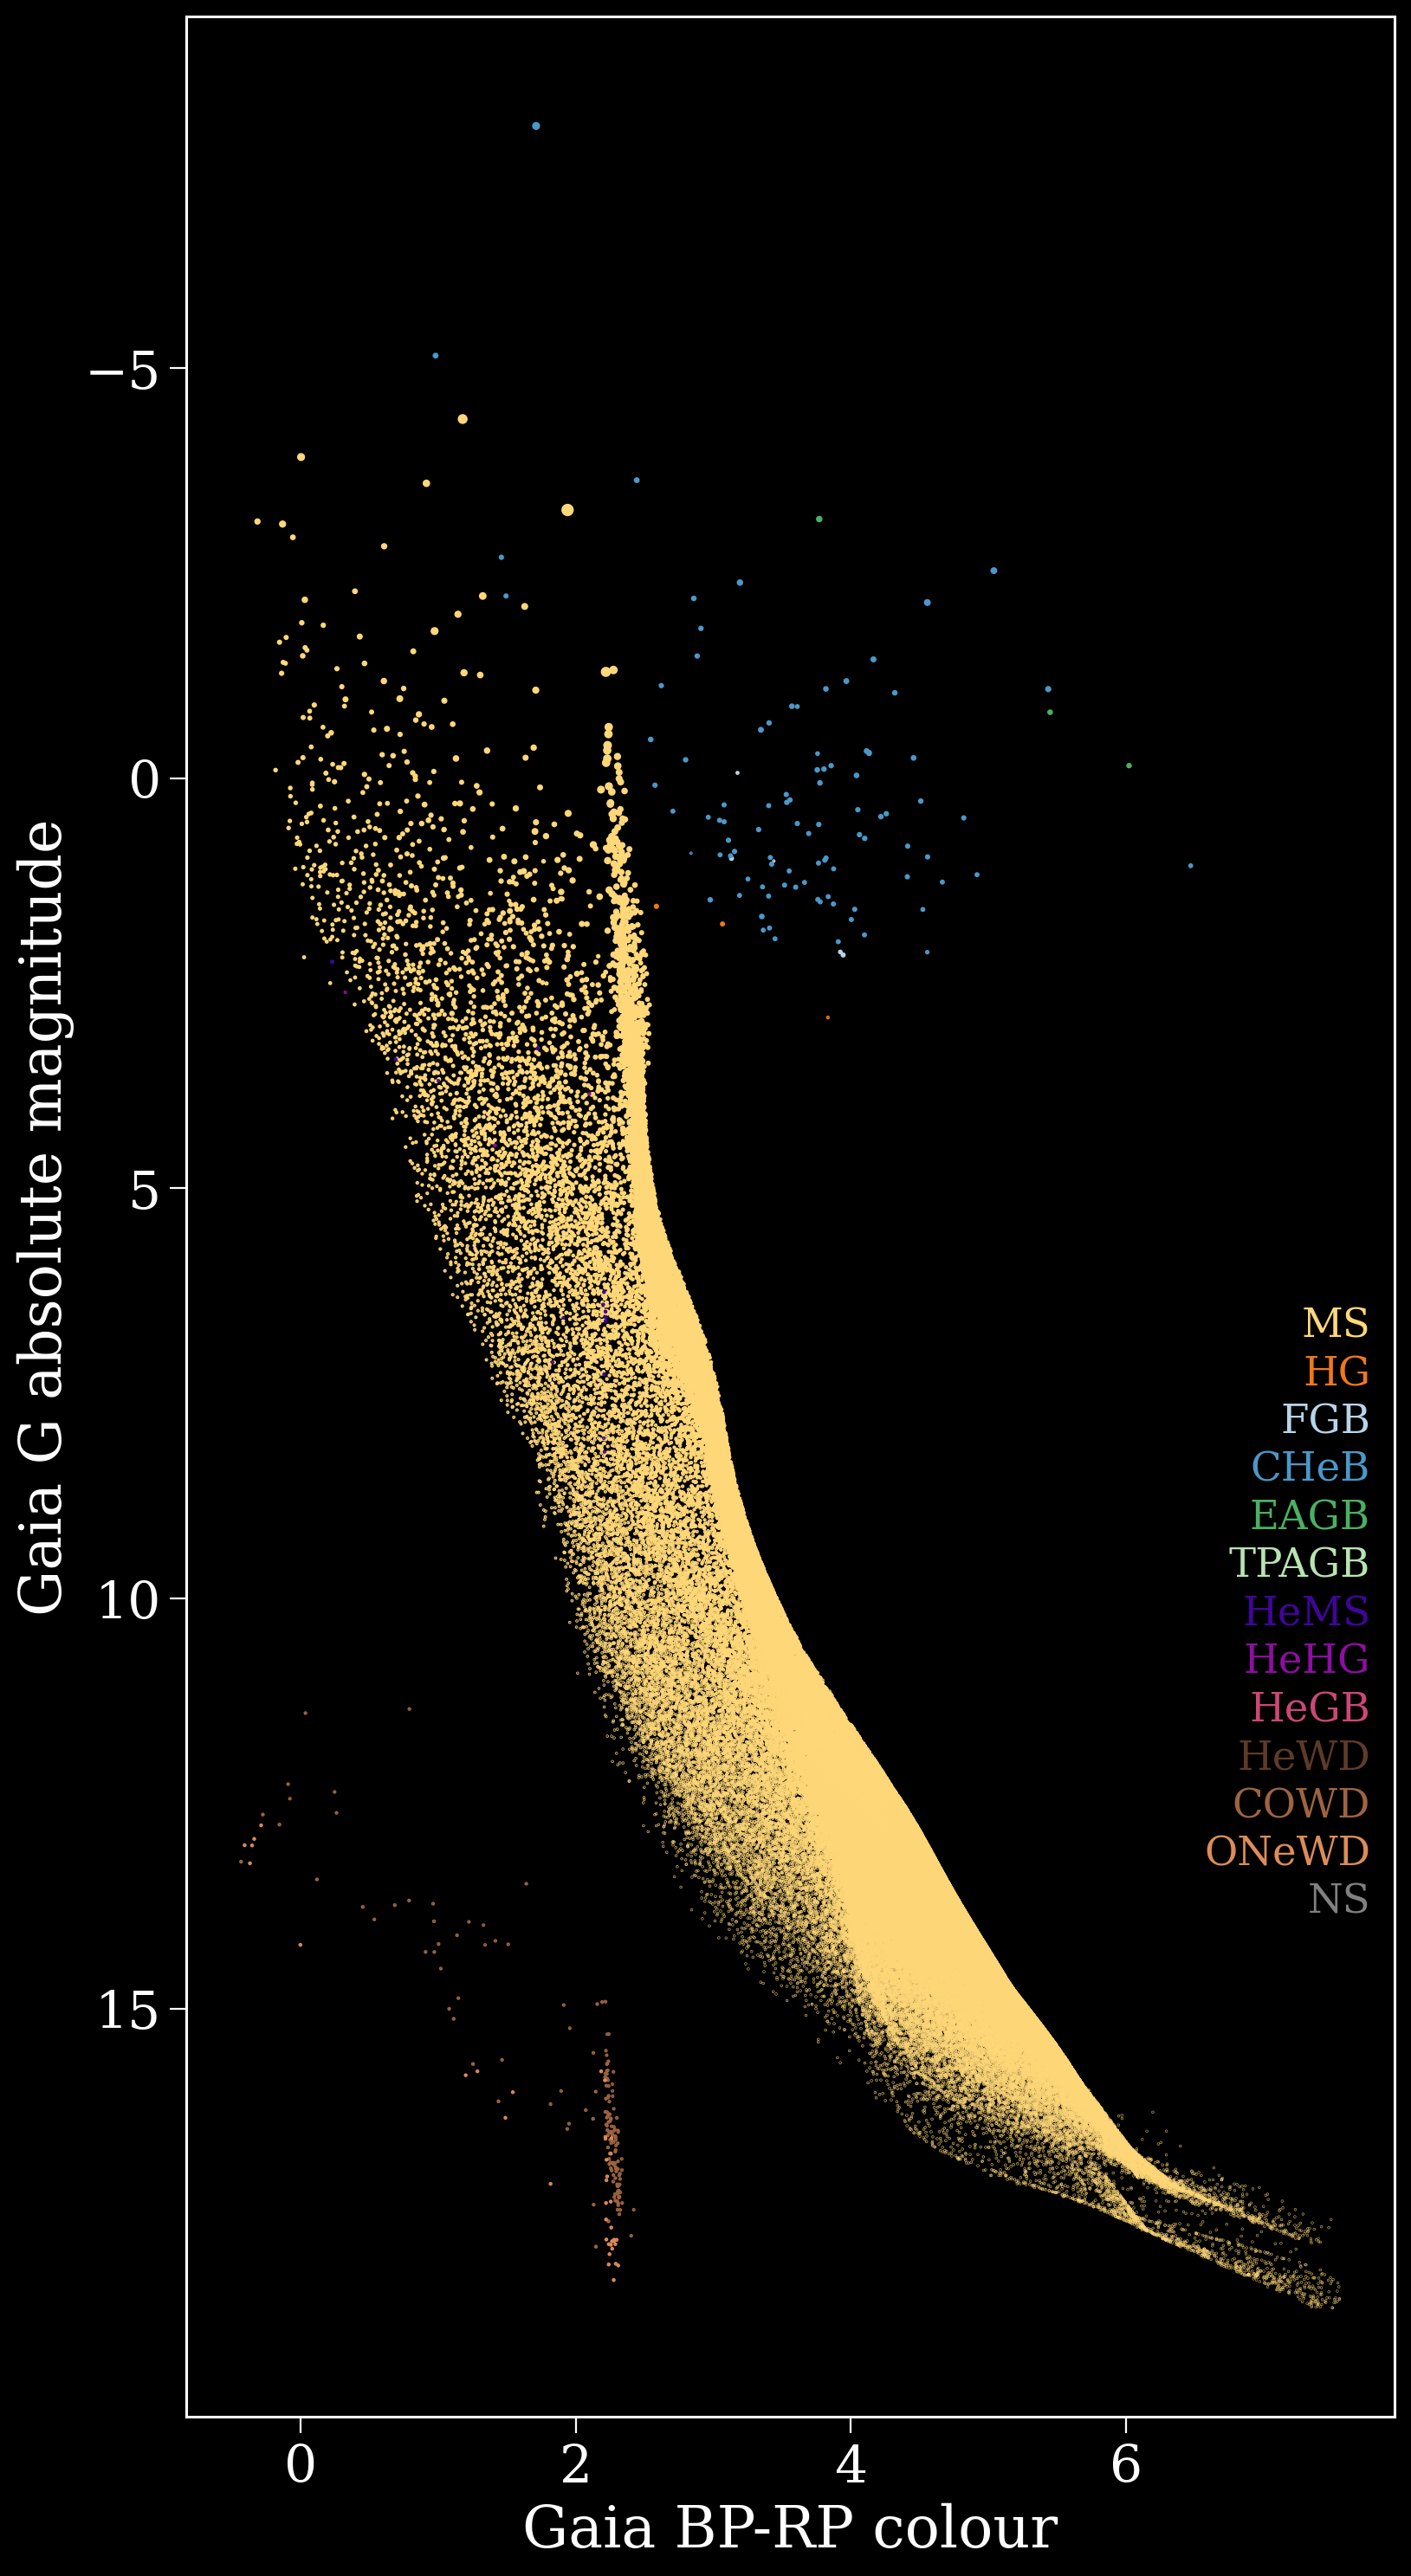

In [45]:
fig, ax = plt.subplots(figsize=(9, 18))

for stellar_type in unique_kstars:
    with np.errstate(invalid='ignore'):
        colour = G_BP_app - G_RP_app
    matching_kstar = kstar == stellar_type
    ax.scatter(colour[matching_kstar], G_abs[matching_kstar], s=0.3 * mass[matching_kstar],
               color=stellar_types[stellar_type]["colour"])

ax.set_ylim(reversed(ax.get_ylim()))

ax.set_xlabel("Gaia BP-RP colour")
ax.set_ylabel("Gaia G absolute magnitude")

stellar_type_range = range(1, 14)
for i, st in enumerate(stellar_type_range):
    ax.annotate(stellar_types[st]["short"], xy=(0.98, 0.2 + 0.02 * (len(stellar_type_range) - 0.5 - i)),
                xycoords="axes fraction", color=stellar_types[st]["colour"], fontsize=0.7*fs, ha="right")

plt.show()

## Distance vs. Apparent Magnitude

### Stellar Types

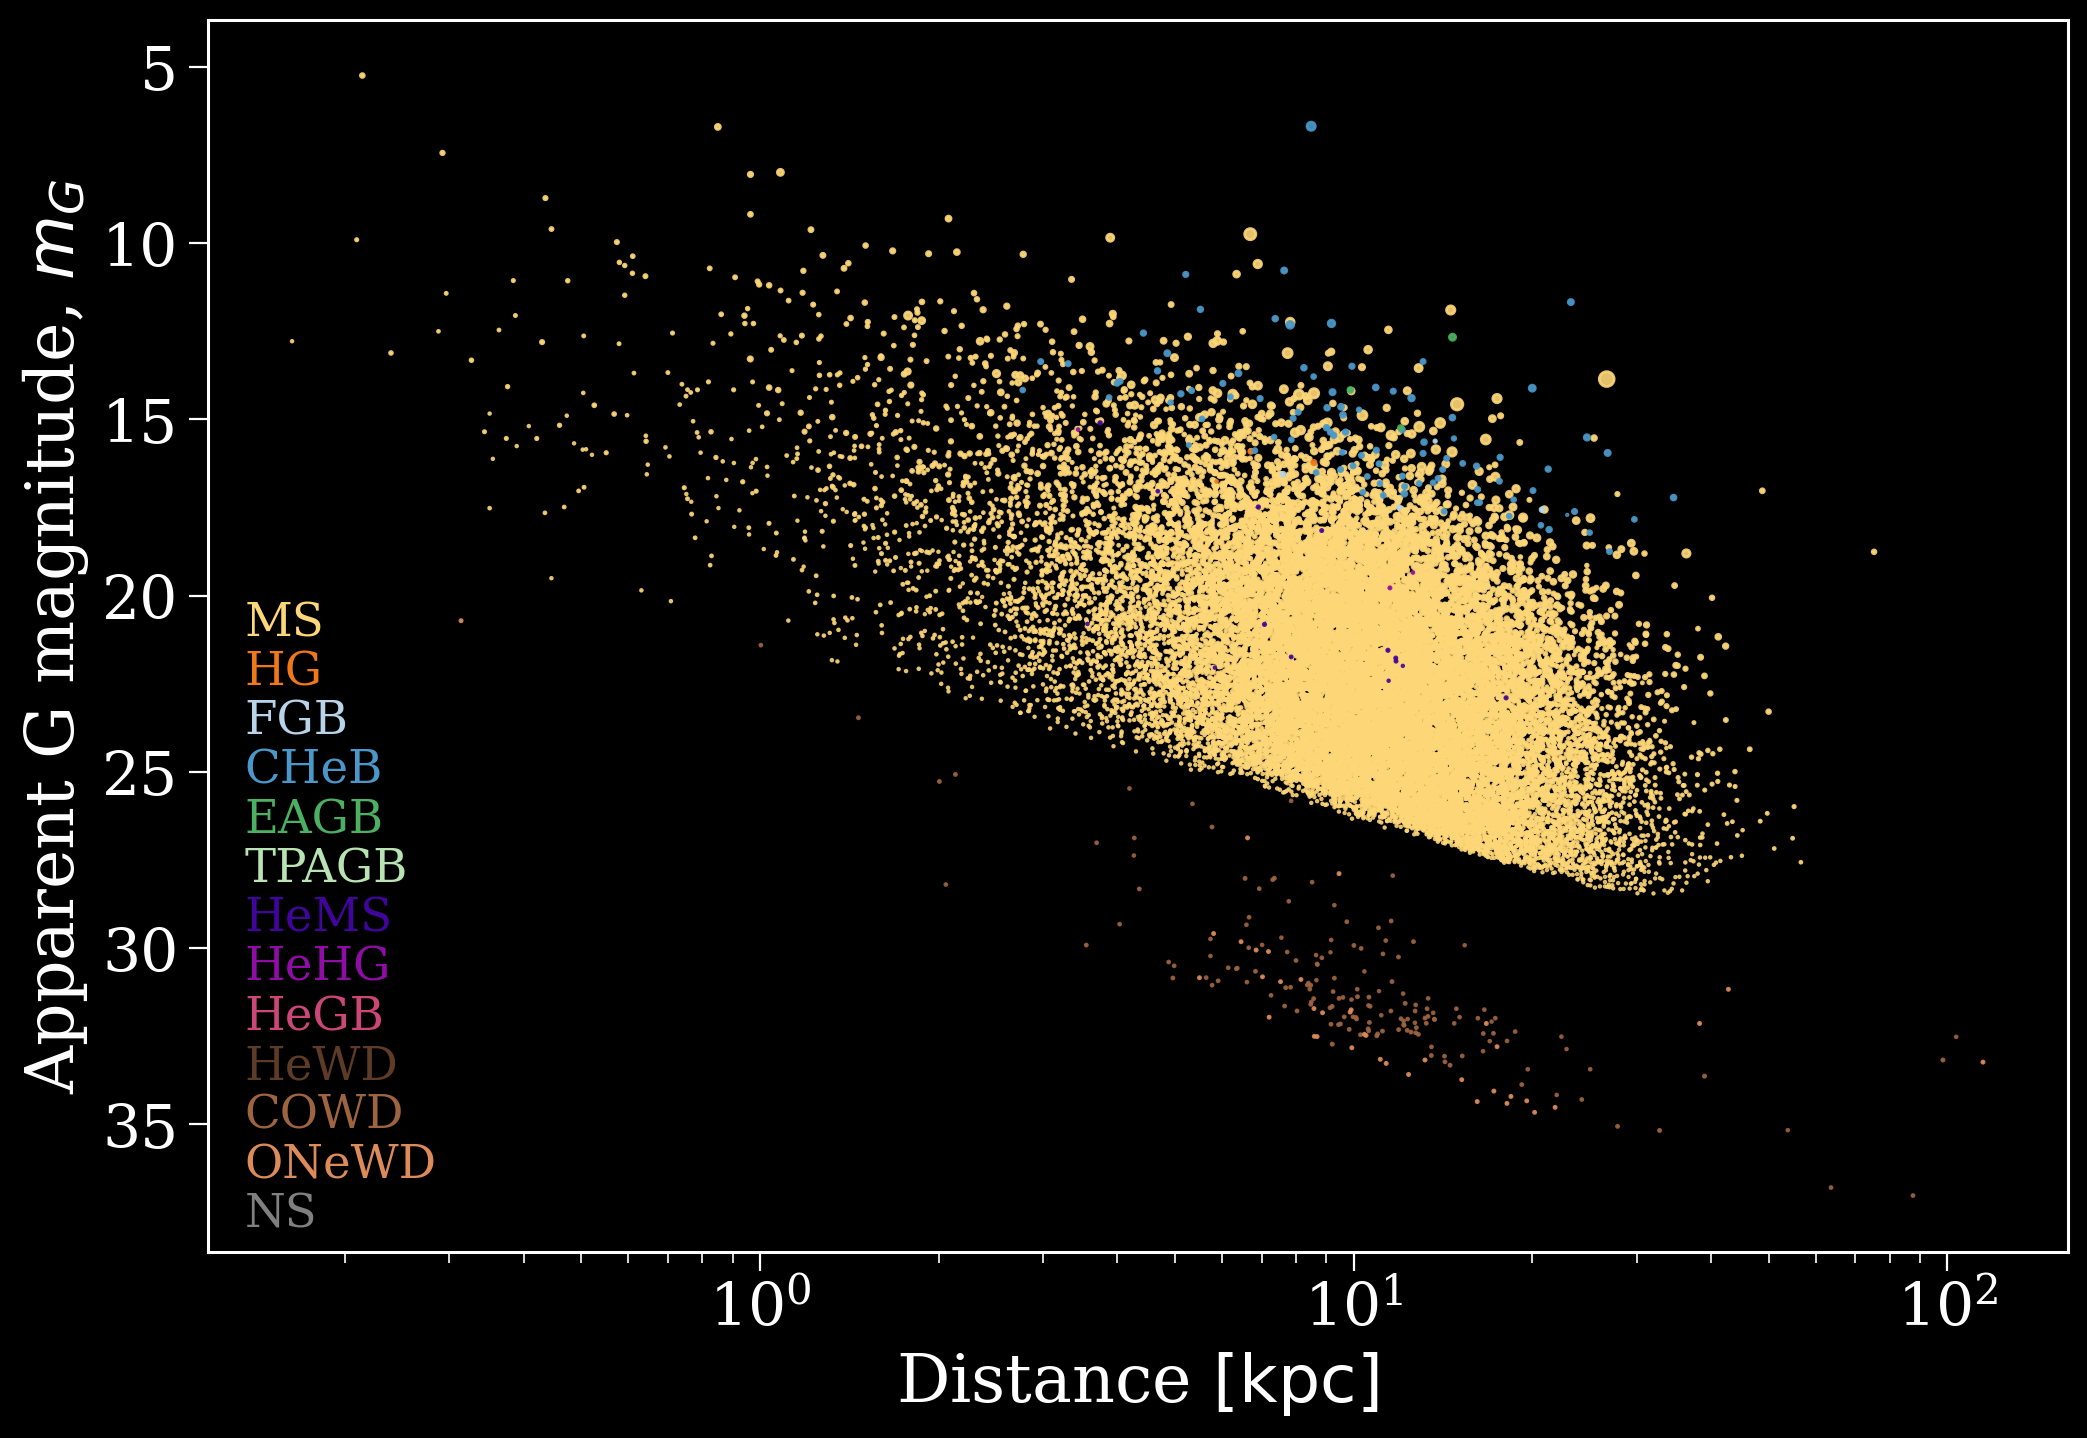

In [28]:
fig, ax = plt.subplots()

for stellar_type in unique_kstars:
    ax.scatter(distances[kstar == stellar_type], G_app[kstar == stellar_type],
               s=0.5 * mass[kstar == stellar_type], alpha=0.9,
               color=stellar_types[stellar_type]["colour"])

ax.set_xlabel(r"Distance $[\rm kpc]$")
ax.set_ylabel(r"Apparent G magnitude, $m_G$")
ax.set_xscale("log")
ax.set_ylim(reversed(ax.get_ylim()))

stellar_type_range = range(1, 14)
for i, st in enumerate(stellar_type_range):
    ax.annotate(stellar_types[st]["short"], xy=(0.02, 0.04 * (len(stellar_type_range) - 0.5 - i)),
                xycoords="axes fraction", color=stellar_types[st]["colour"], fontsize=0.7*fs)

plt.show()

### Luminosity

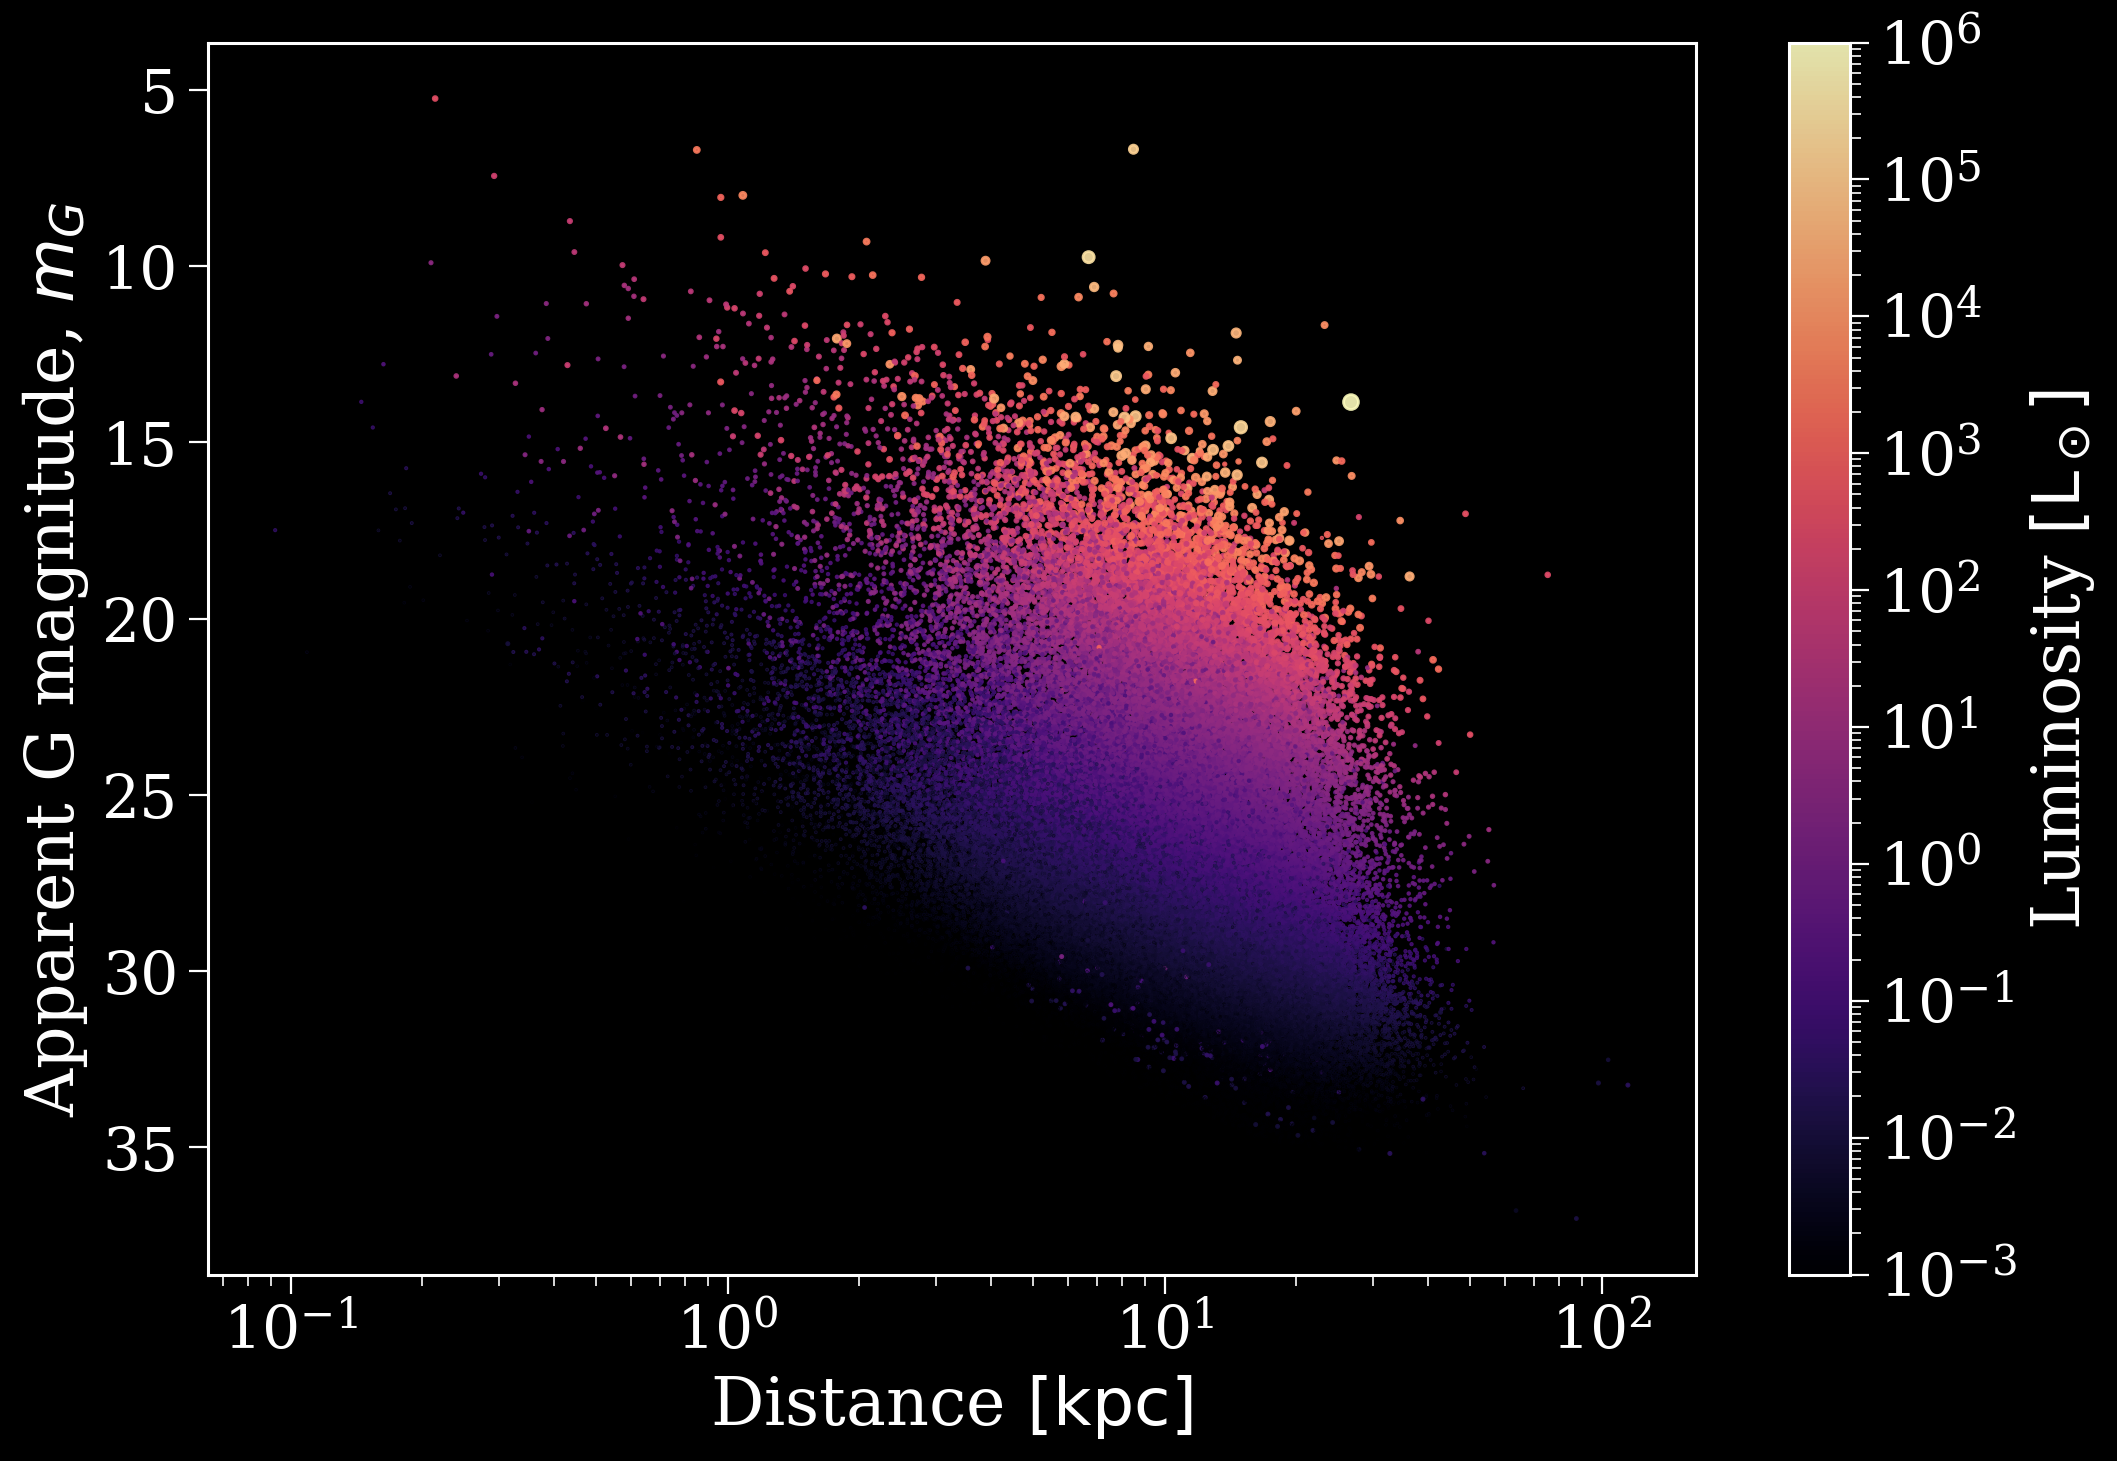

In [15]:
fig, ax = plt.subplots()

scatter = ax.scatter(distances, G_app, s=0.5 * mass, alpha=0.9,
                     c=lum, norm=LogNorm(vmin=1e-3, vmax=1e6), cmap="magma")

cbar = fig.colorbar(scatter, label=r"Luminosity $[\rm L_\odot]$")

ax.set_xlabel(r"Distance $[\rm kpc]$")
ax.set_ylabel(r"Apparent G magnitude, $m_G$")
ax.set_xscale("log")
ax.set_ylim(reversed(ax.get_ylim()))

plt.show()

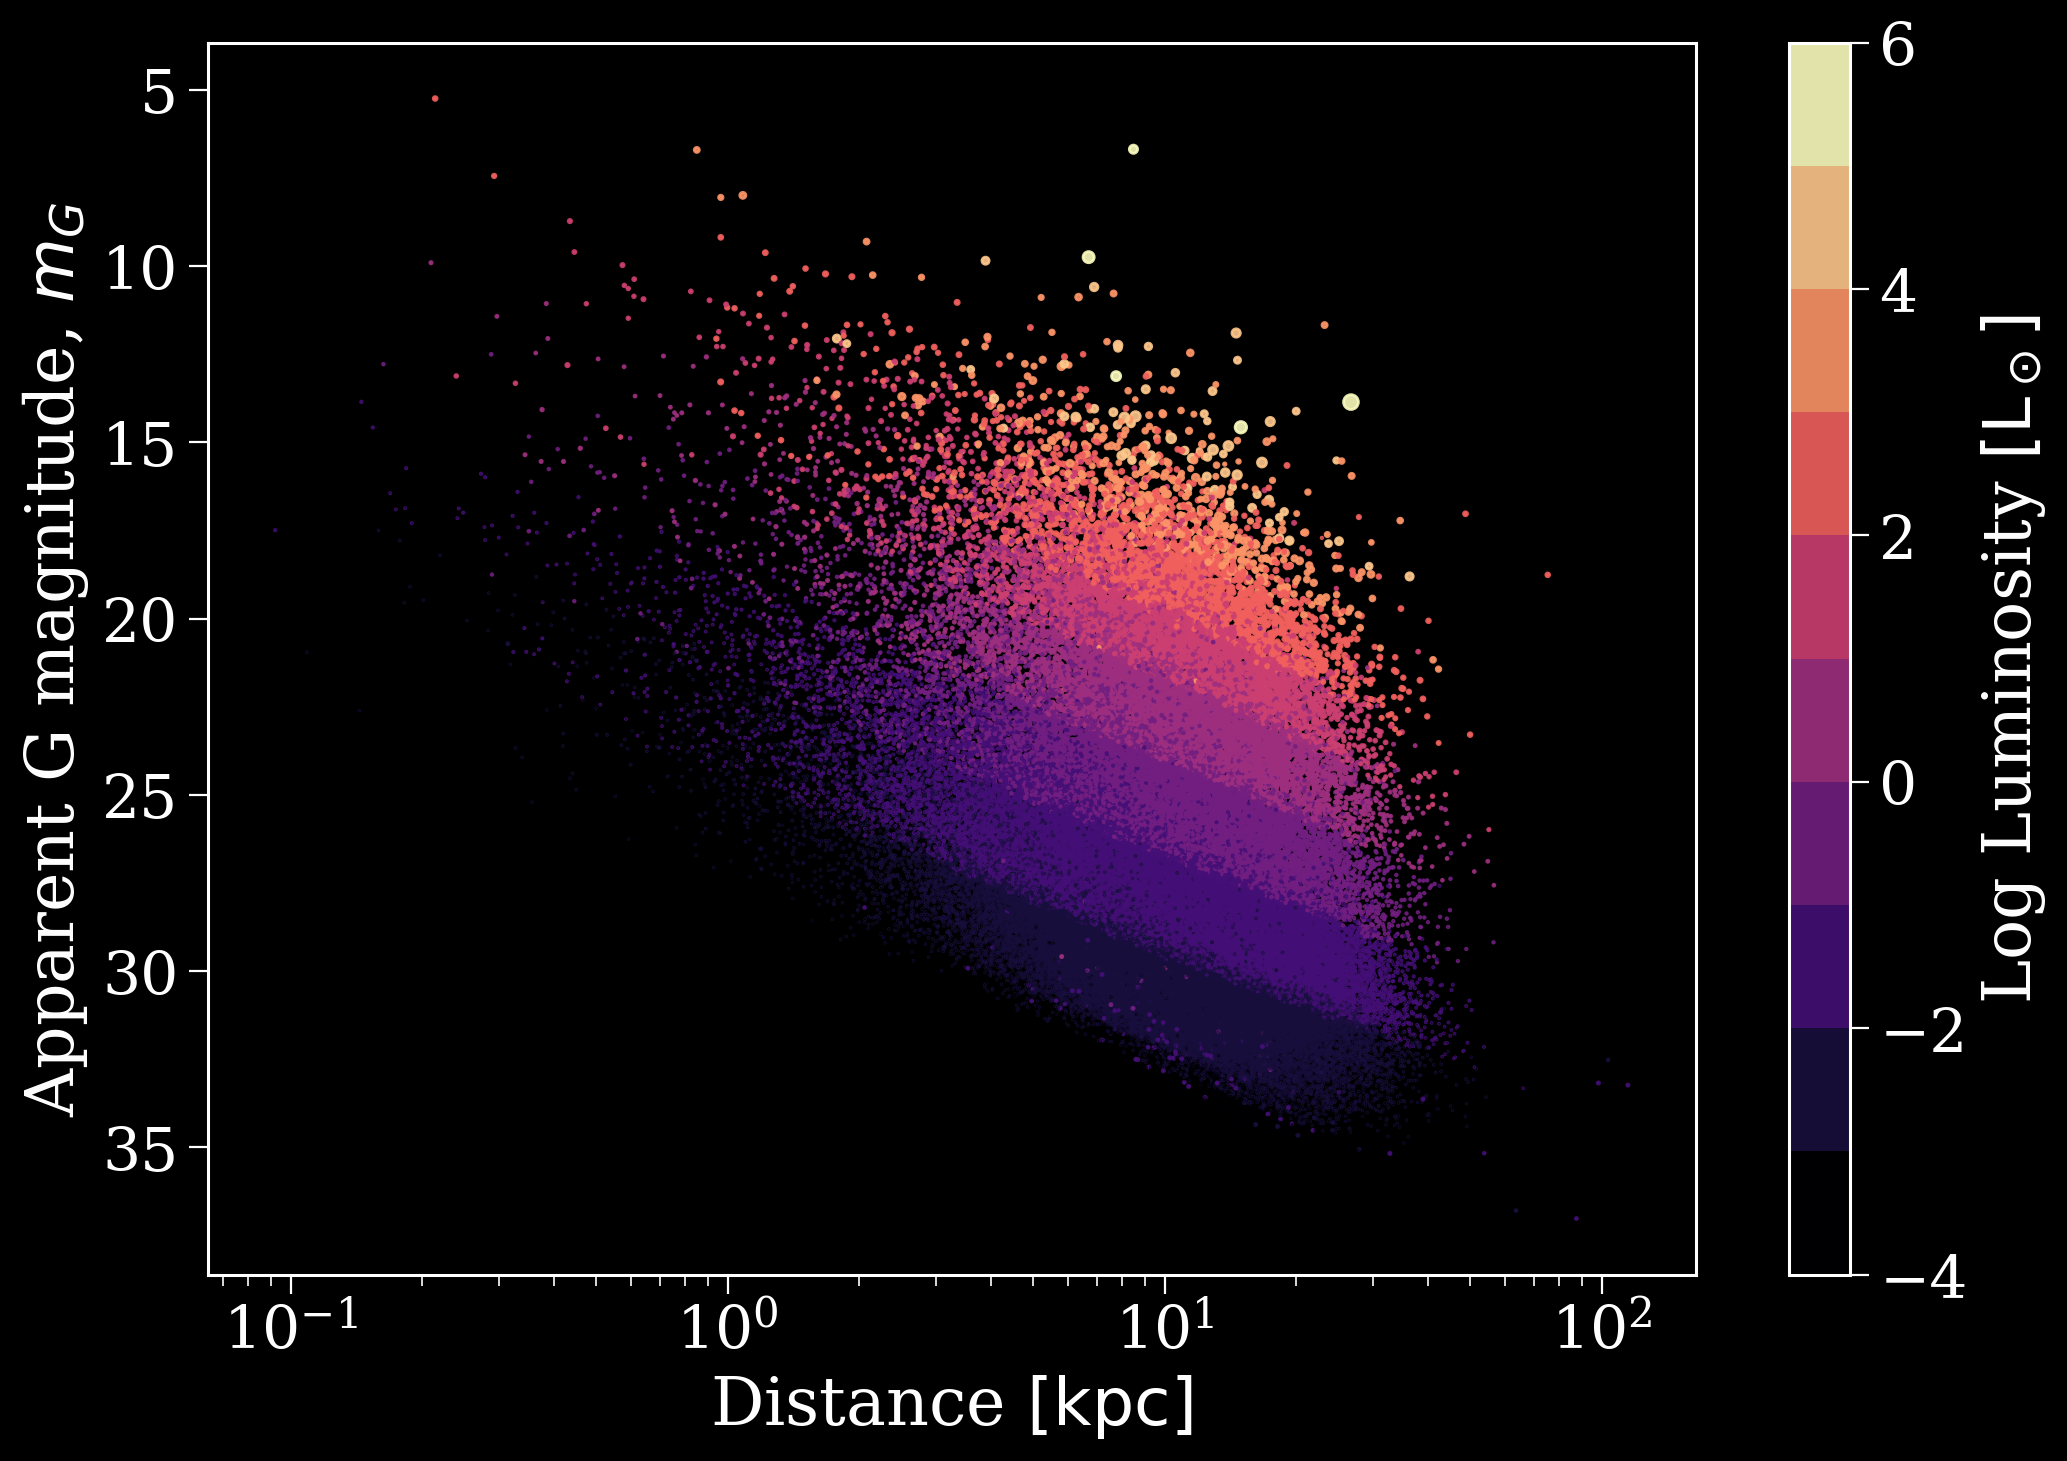

In [11]:
fig, ax = plt.subplots()

boundaries = [-4, -2, 0, 2, 4, 6]
boundaries = np.linspace(-4, 6, 11)

scatter = ax.scatter(distances, G_app, s=0.5 * mass, alpha=0.9,
                     c=np.log10(lum), norm=BoundaryNorm(boundaries=boundaries, ncolors=256), cmap="magma")

cbar = fig.colorbar(scatter, label=r"Log Luminosity $[\rm L_\odot]$")

ax.set_xlabel(r"Distance $[\rm kpc]$")
ax.set_ylabel(r"Apparent G magnitude, $m_G$")
ax.set_xscale("log")
ax.set_ylim(reversed(ax.get_ylim()))

plt.show()

In [16]:
p.observables

Av_1  Av_2    M_abs_1    m_app_1    M_abs_2    m_app_2    J_app_1  \
0       6.000   6.0  10.330485  26.067570  12.065176  27.802261  25.752917   
1       6.000   6.0  11.684335  26.358127  12.333905  27.007697  25.629828   
2       5.504   6.0   6.667053  21.272434   8.497458  23.102839  21.183193   
3       6.000   6.0  10.177289  23.027688  12.313926  25.164324  22.752081   
4       3.136   6.0  11.723841  24.232170  12.510402  25.018731  22.926446   
...       ...   ...        ...        ...        ...        ...        ...   
132431  6.000   6.0  11.642932  26.672689  12.810122  27.839879  26.079059   
132432  2.880   6.0   6.257295  19.976630   6.965390  20.684725  19.160879   
132433  4.896   6.0  10.084065  24.668062  10.932771  25.516768  23.949228   
132434  6.000   6.0   8.880109  23.182522  11.651739  25.954152  23.061853   
132435  6.000   6.0   8.061110  24.995590   9.318900  26.253380  24.855315   

        J_app_2    J_abs_1  J_abs_2    H_app_1  H_app_2   H_abs_1  H_abs_2  \
0           inf  10.015832      inf  24.467725      inf  8.730640      inf   
1           inf  10.956036      inf  24.351856      inf  9.678065      inf   
2           inf   6.577812      inf  19.965157      inf  5.359776      inf   
3           inf   9.901682      inf  21.474908      inf  8.624510      inf   
4           inf  10.418116      inf  21.907530      inf  9.399201      inf   
...         ...        ...      ...        ...      ...       ...      ...   
132431      inf  11.049302      inf  24.835948      inf  9.806191      inf   
132432      inf   5.441544      inf  18.216090      inf  4.496755      inf   
132433      inf   9.365231      inf  22.747864      inf  8.163867      inf   
132434      inf   8.759441      inf  21.743138      inf  7.440725      inf   
132435      inf   7.920836      inf  23.560066      inf  6.625587      inf   

          K_app_1  K_app_2   K_abs_1  K_abs_2    G_app_1  G_app_2  \
0       23.868550      inf  8.131465      inf  30.406771      inf   
1       23.734048      inf  9.060256      inf  30.635293      inf   
2       19.494743      inf  4.889363      inf  25.121297      inf   
3       20.877328      inf  8.026929      inf  27.448639      inf   
4       21.422732      inf  8.914403      inf  27.324851      inf   
...           ...      ...       ...      ...        ...      ...   
132431  24.208295      inf  9.178538      inf  31.160321      inf   
132432  17.881422      inf  4.162087      inf  22.111959      inf   
132433  22.202657      inf  7.618660      inf  28.286239      inf   
132434  21.169445      inf  6.867032      inf  27.583158      inf   
132435  23.015097      inf  6.080617      inf  29.043024      inf   

           teff_obs  log_g_obs  secondary_brighter    G_abs_1  G_abs_2  \
0       3420.308931   4.979301               False  14.669686      inf   
1       3050.195052   5.061681               False  15.961501      inf   
2       4564.166129   4.613781               False  10.515916      inf   
3       3407.098898   4.953840               False  14.598240      inf   
4       3017.715210   5.051977               False  14.816522      inf   
...             ...        ...                 ...        ...      ...   
132431  3026.668857   5.037350               False  16.130564      inf   
132432  4828.247409   4.591037               False   8.392624      inf   
132433  3480.992802   4.964169               False  13.702242      inf   
132434  3678.555512   4.841067               False  13.280746      inf   
132435  4117.544725   4.794590               False  12.108544      inf   

         BP_app_1  BP_app_2   BP_abs_1  BP_abs_2   RP_app_1  RP_app_2  \
0       33.748987       inf  18.011902       inf  29.021955       inf   
1       34.799096       inf  20.125304       inf  29.211867       inf   
2       27.266435       inf  12.661054       inf  23.857969       inf   
3       30.894417       inf  18.044018       inf  26.057935       inf   
4       30.506987       inf  17.998658       inf  25

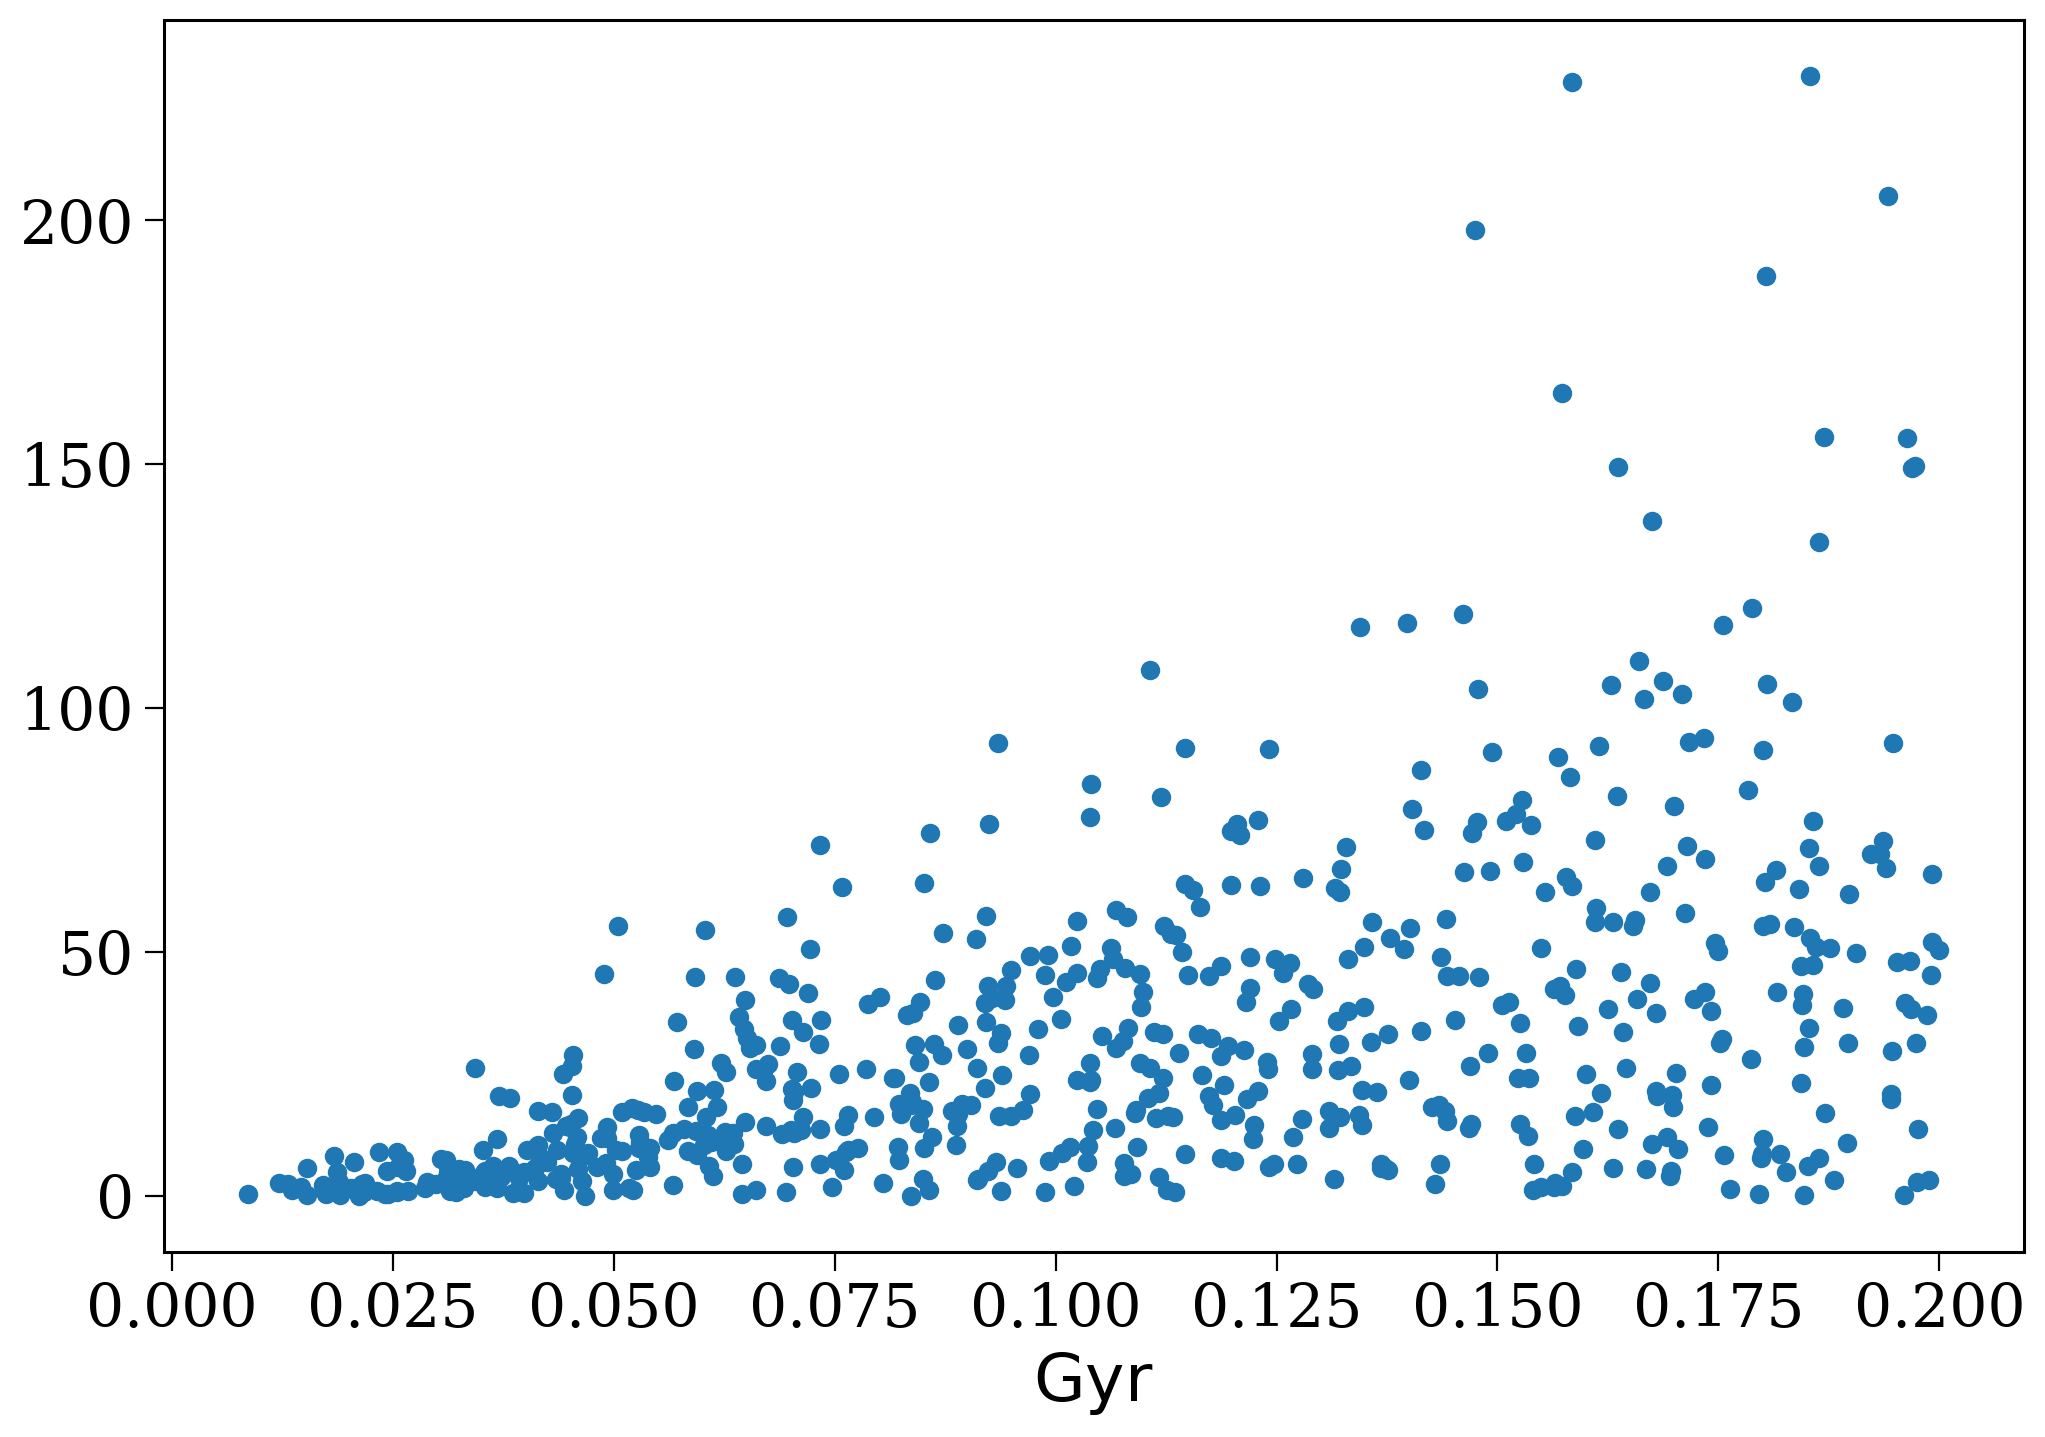

In [39]:
plt.scatter(p.initial_galaxy.tau[p.final_bpp["sep"] < 0],
            disrupted_sep[p.final_bpp["sep"] < 0.0].value)

# Load in the populations

In [10]:
class RecentHistory(kicker.galaxy.Frankel2018):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1], **kwargs):
        super().__init__(components=components, component_masses=component_masses, **kwargs)

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        if component != "low_alpha_disc":
            raise NotImplementedError()

        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(200 * u.Myr / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau

In [4]:
p_list = [kicker.pop.load(f"data/pop-{i}") for i in range(5)]

In [5]:
for p in p_list:
    p.classes

# Get some of the final distributions

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(163.6065414 ,  61.96493464,    9.70990997),
     (230.39757242, -21.05595832, 3472.4464684 ),
     (275.89194418,  14.97515969,   15.46280133), ...,
     (221.33502951, -51.65846668,    8.16492653),
     (233.878825  , -29.3362076 ,    5.2157425 ),
     ( 54.19084057, -47.59609796,   11.64527629)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-2.9704062 , -6.35256907e+00, -169.73413845),
     (-0.01003822, -1.06703256e-02,  404.18682673),
     (-3.53367772, -1.04177564e-01, -110.2888967 ), ...,
     (-2.62654257, -1.42017107e+00,  338.30154824),
     ( 1.91970317, -1.12344522e+01,  248.76304951),
     ( 2.8145896 , -2.32560439e+00,  171.44688768)]>

In [22]:
p.initial_galaxy.__class__.__bases__

(kicker.galaxy.Galaxy,)

In [10]:
for p in p_list:
    p.final_bpp = p.bpp[~p.bpp.index.duplicated(keep="last")]
    
    # get final positions and velocities
    final_kinematics = np.zeros((len(p.orbits), 2, 6))
    for i, orbit in enumerate(p.orbits):
        if isinstance(orbit, list):
            final_kinematics[i, 0, :3] = orbit[0][-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 1, :3] = orbit[1][-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 0, 3:] = orbit[0][-1].vel.d_xyz.to(u.km / u.s)
            final_kinematics[i, 1, 3:] = orbit[1][-1].vel.d_xyz.to(u.km / u.s)
        else:
            final_kinematics[i, 0, :3] = orbit[-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 0, 3:] = orbit[-1].vel.d_xyz.to(u.km / u.s)
            
    for i in [1, 2]:
        df = pd.DataFrame(final_kinematics[:, i - 1, :], columns=[f"x_{i}", f"y_{i}", f"z_{i}",
                                                                  f"v_x_{i}", f"v_y_{i}", f"v_z_{i}"])
        df.index = p.final_bpp.index
        p.final_bpp = p.final_bpp.join(df)

In [25]:
def grid_plot(x_var, y_var, x_label, y_label):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]})

    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    disrupted = final_binaries["sep"] < 0
    kicked = final_binaries.index.isin(kicked_nums)

    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][~kicked]), np.abs(final_binaries[f"{y_var}_1"][~kicked]), s=5, label=f"No supernova ({len(final_binaries[~kicked])})")

    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][kicked]), np.abs(final_binaries[f"{y_var}_1"][kicked]), s=10, color="C1", label=f"At least 1 supernova ({len(final_binaries[kicked])})")
    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_2"][kicked & disrupted]), np.abs(final_binaries[f"{y_var}_2"][kicked & disrupted]), s=5, color="C1")

    axes[1, 0].set_xscale("log")
    axes[1, 0].set_yscale("log")

    axes[1, 0].set_xlabel(x_label)
    axes[1, 0].set_ylabel(y_label)

    axes[1, 0].legend(fontsize=0.7*fs, markerscale=5, handletextpad=0.0)

    axes[0, 1].axis("off")

    x_bins = np.logspace(np.log10(np.abs(final_binaries[f"{x_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{x_var}_1"]).max()), 50)
    axes[0, 0].hist(np.abs(final_binaries[f"{x_var}_1"][~kicked]), bins=x_bins, log=True)
    axes[0, 0].hist(np.abs(np.concatenate((final_binaries[f"{x_var}_1"][kicked], final_binaries[f"{x_var}_2"][kicked]))), bins=x_bins, log=True, alpha=0.5)
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel(r"$N_{\rm binary}$")

    y_bins = np.logspace(np.log10(np.abs(final_binaries[f"{y_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{y_var}_1"]).max()), 50)
    axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][~kicked]), bins=y_bins, orientation="horizontal", log=True)
    axes[1, 1].hist(np.abs(np.concatenate((final_binaries[f"{y_var}_1"][kicked], final_binaries[f"{y_var}_2"][kicked]))), bins=y_bins, orientation="horizontal", log=True, alpha=0.5)
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel(r"$N_{\rm binary}$")

    plt.show()

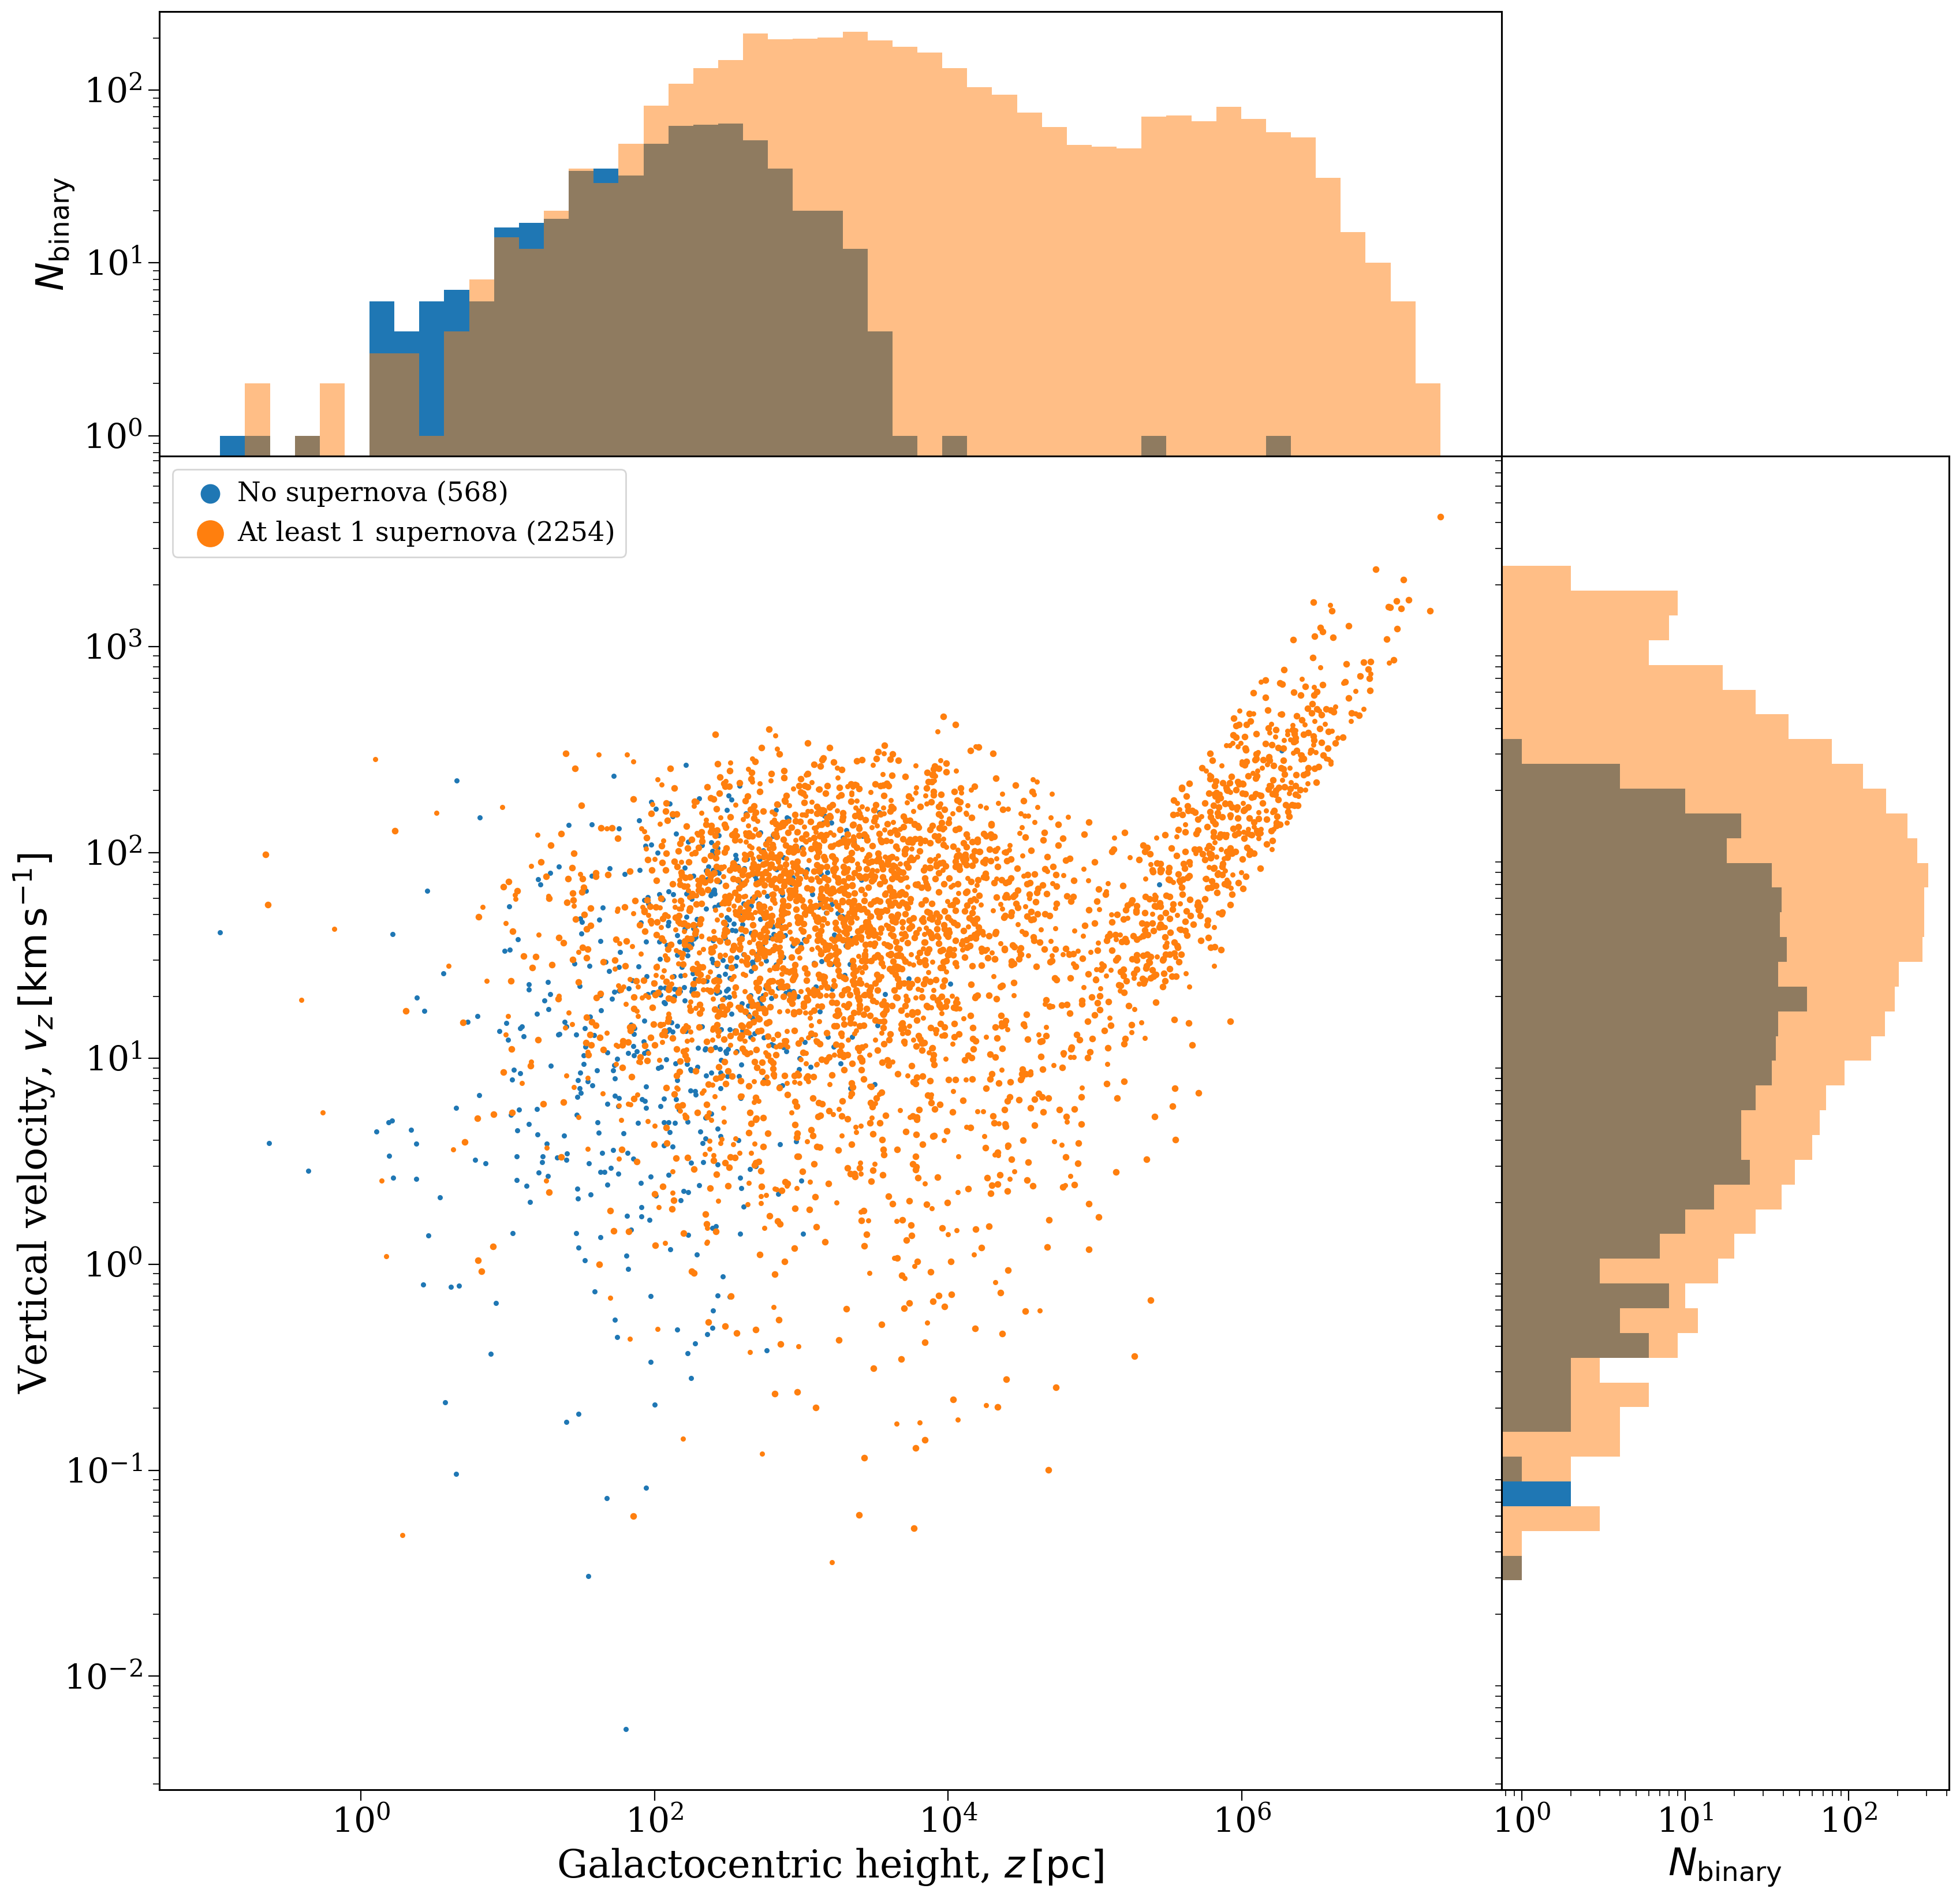

In [17]:
grid_plot("z", "v_z", r"Galactocentric height, $z\,[\rm pc]$", r"Vertical velocity, $v_z\,[\rm km \, s^{-1}]$")

In [18]:
for ind in [1, 2]:
    final_binaries[f"dist_{ind}"] = np.sqrt(final_binaries[f"x_{ind}"]**2 + final_binaries[f"y_{ind}"]**2 + final_binaries[f"z_{ind}"]**2)
    final_binaries[f"speed_{ind}"] = np.sqrt(final_binaries[f"v_x_{ind}"]**2 + final_binaries[f"v_y_{ind}"]**2 + final_binaries[f"v_z_{ind}"]**2)

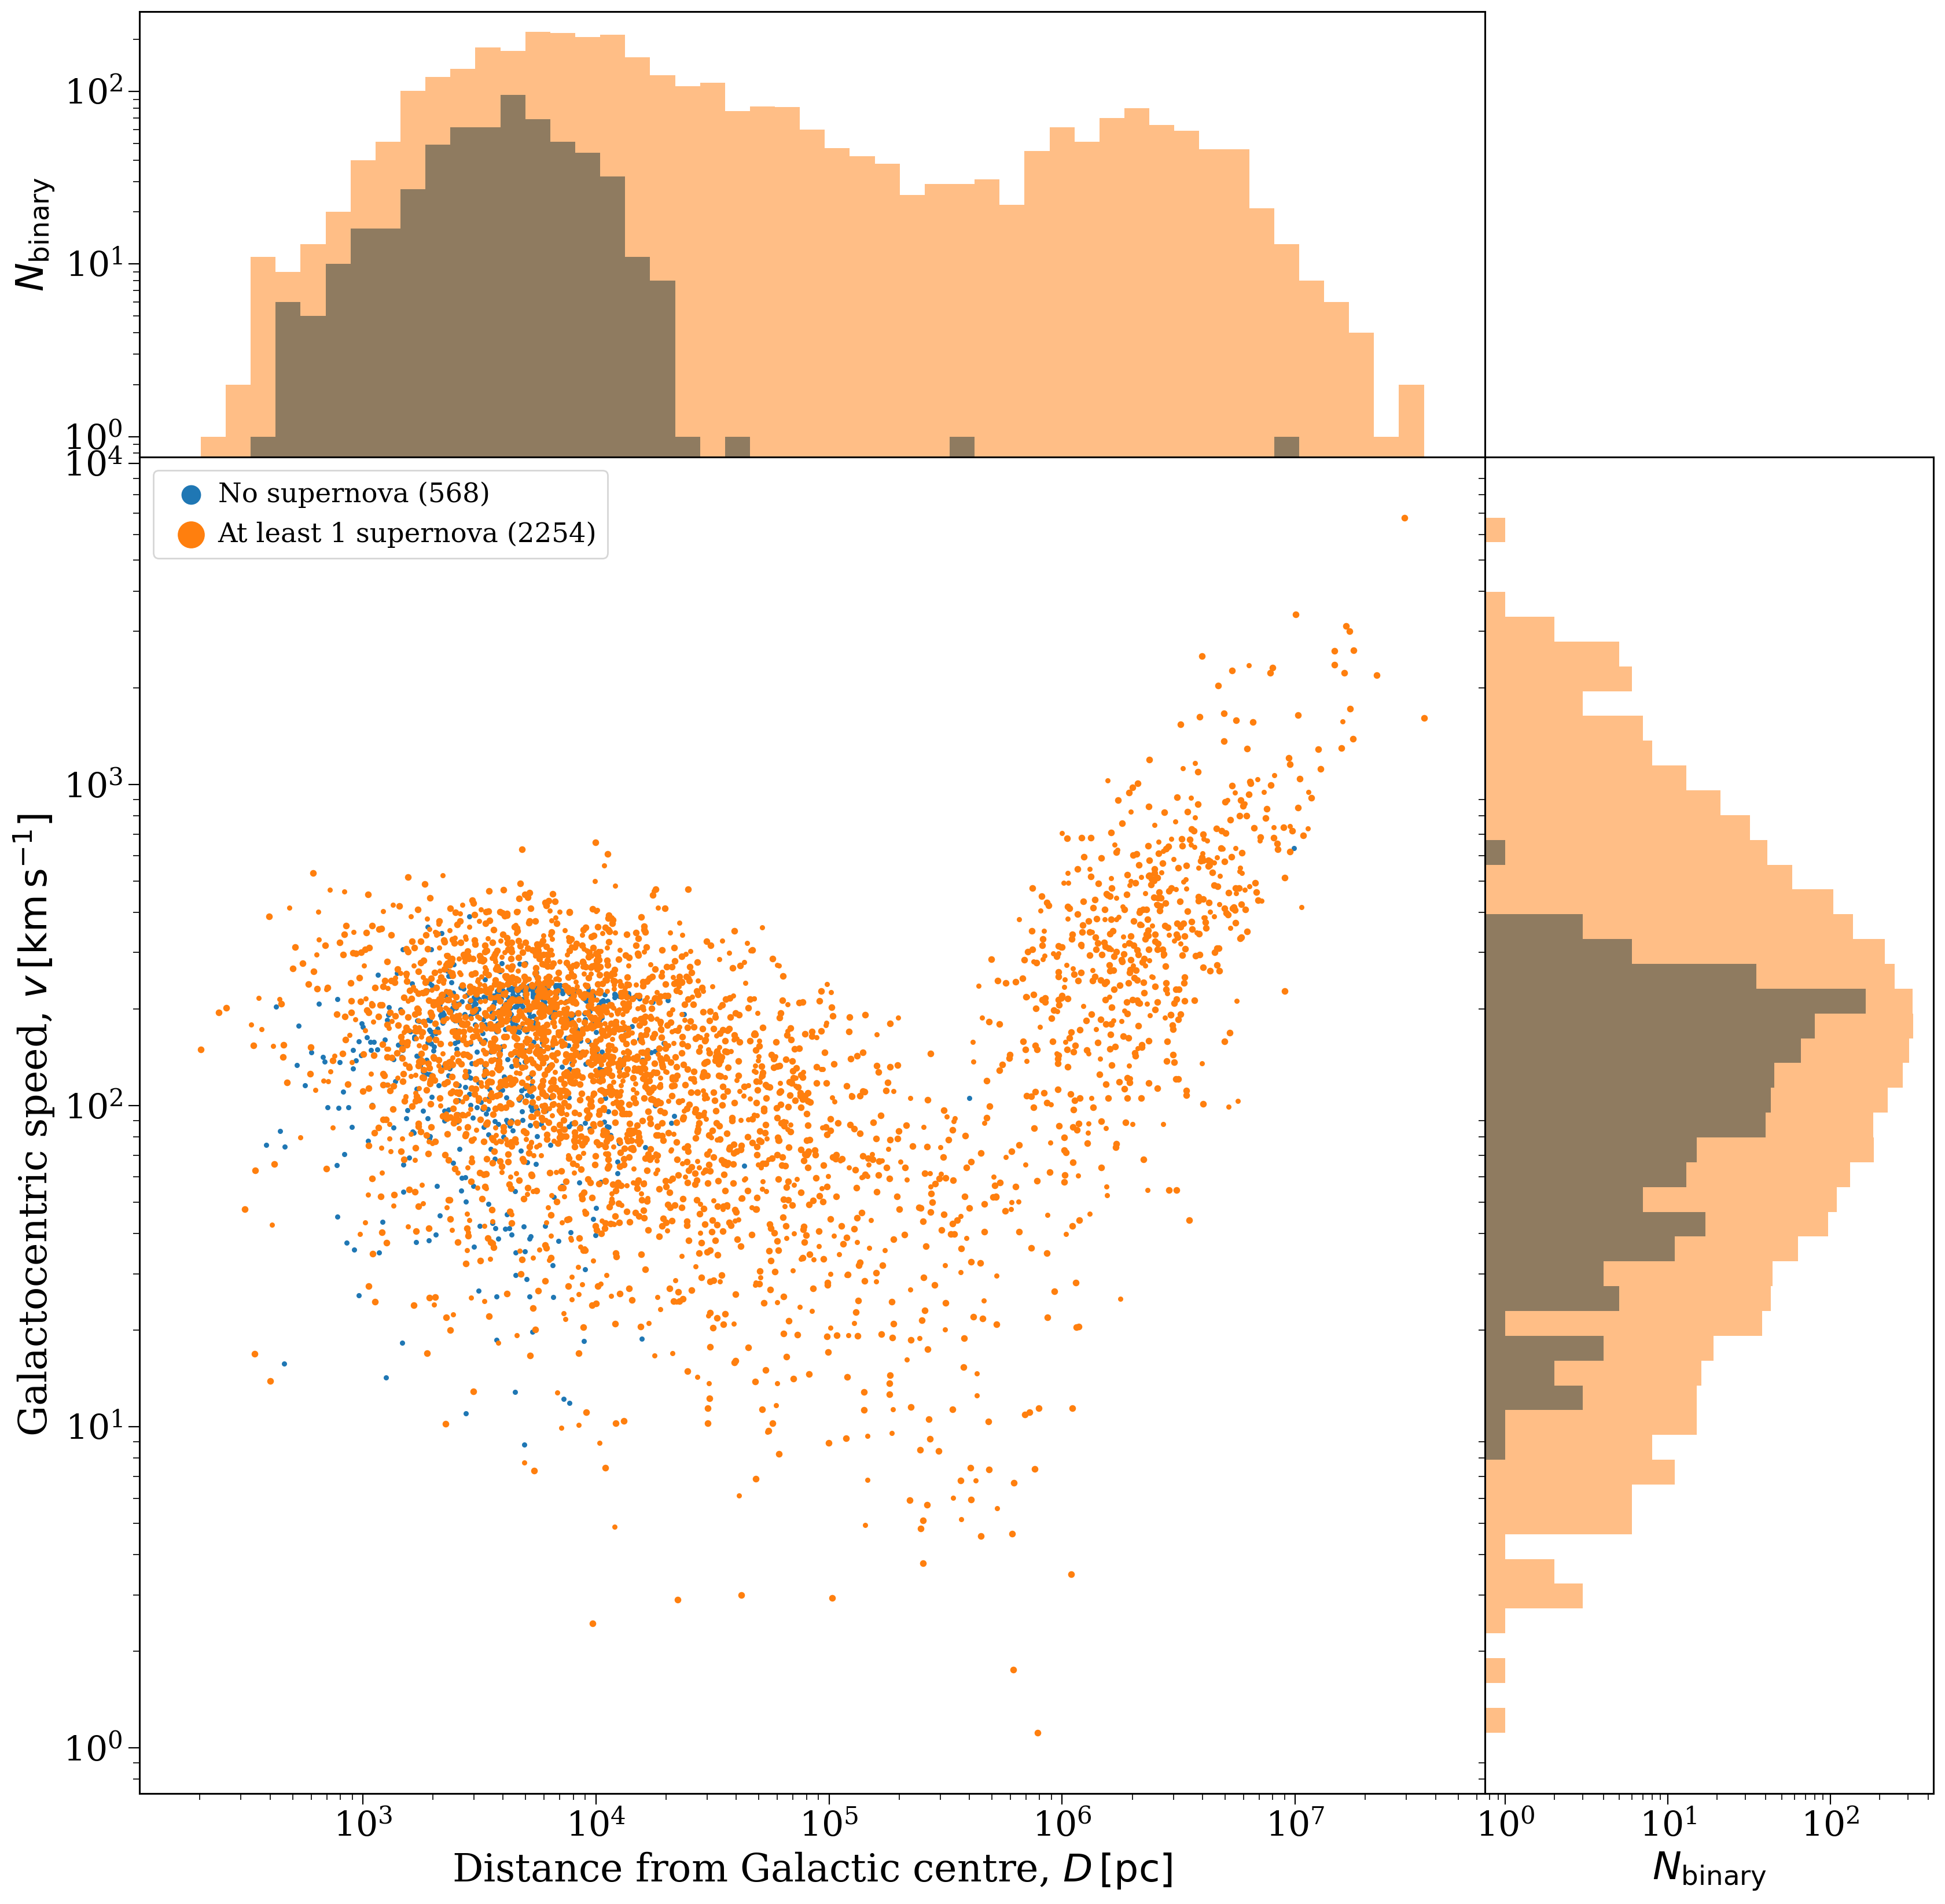

In [23]:
grid_plot("dist", "speed", r"Distance from Galactic centre, $D\,[\rm pc]$", r"Galactocentric speed, $v\,[\rm km \, s^{-1}]$")

In [20]:
def grid_plot_by_mass(x_var, y_var, x_label, y_label, mass_lims=[0.0, 0.1, 1.5, 7.0, 20, np.inf], sizes=[1, 1, 10, 10, 10]):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]})

    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    disrupted = final_binaries["sep"] < 0

    x_bins = np.logspace(np.log10(np.abs(final_binaries[f"{x_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{x_var}_1"]).max()), 50)
    y_bins = np.logspace(np.log10(np.abs(final_binaries[f"{y_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{y_var}_1"]).max()), 50)
    for i in range(len(mass_lims) - 1):
        mass_mask = ((p.initial_binaries["mass_1"] >= mass_lims[i]) & (p.initial_binaries["mass_1"] < mass_lims[i + 1])).values
        label = f"{mass_lims[i]} " + r"$\leq m_{1, i} <$" + f" {mass_lims[i + 1]}   ({len(final_binaries[mass_mask])})"
        axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][mass_mask]), np.abs(final_binaries[f"{y_var}_1"][mass_mask]), s=sizes[i], label=label)
        axes[0, 0].hist(np.abs(final_binaries[f"{x_var}_1"][mass_mask]), bins=x_bins, log=True, histtype="step")
        axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][mass_mask]), bins=y_bins, orientation="horizontal", log=True, histtype="step")

    axes[1, 0].set_xscale("log")
    axes[1, 0].set_yscale("log")

    axes[1, 0].set_xlabel(x_label)
    axes[1, 0].set_ylabel(y_label)

    axes[1, 0].legend(fontsize=0.7*fs, markerscale=5, handletextpad=0.0)

    axes[0, 1].axis("off")
    
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel(r"$N_{\rm binary}$")

    # axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][~kicked]), bins=y_bins, orientation="horizontal", log=True)
    # axes[1, 1].hist(np.abs(np.concatenate((final_binaries[f"{y_var}_1"][kicked], final_binaries[f"{y_var}_2"][kicked]))), bins=y_bins, orientation="horizontal", log=True, alpha=0.5)
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel(r"$N_{\rm binary}$")

    plt.show()

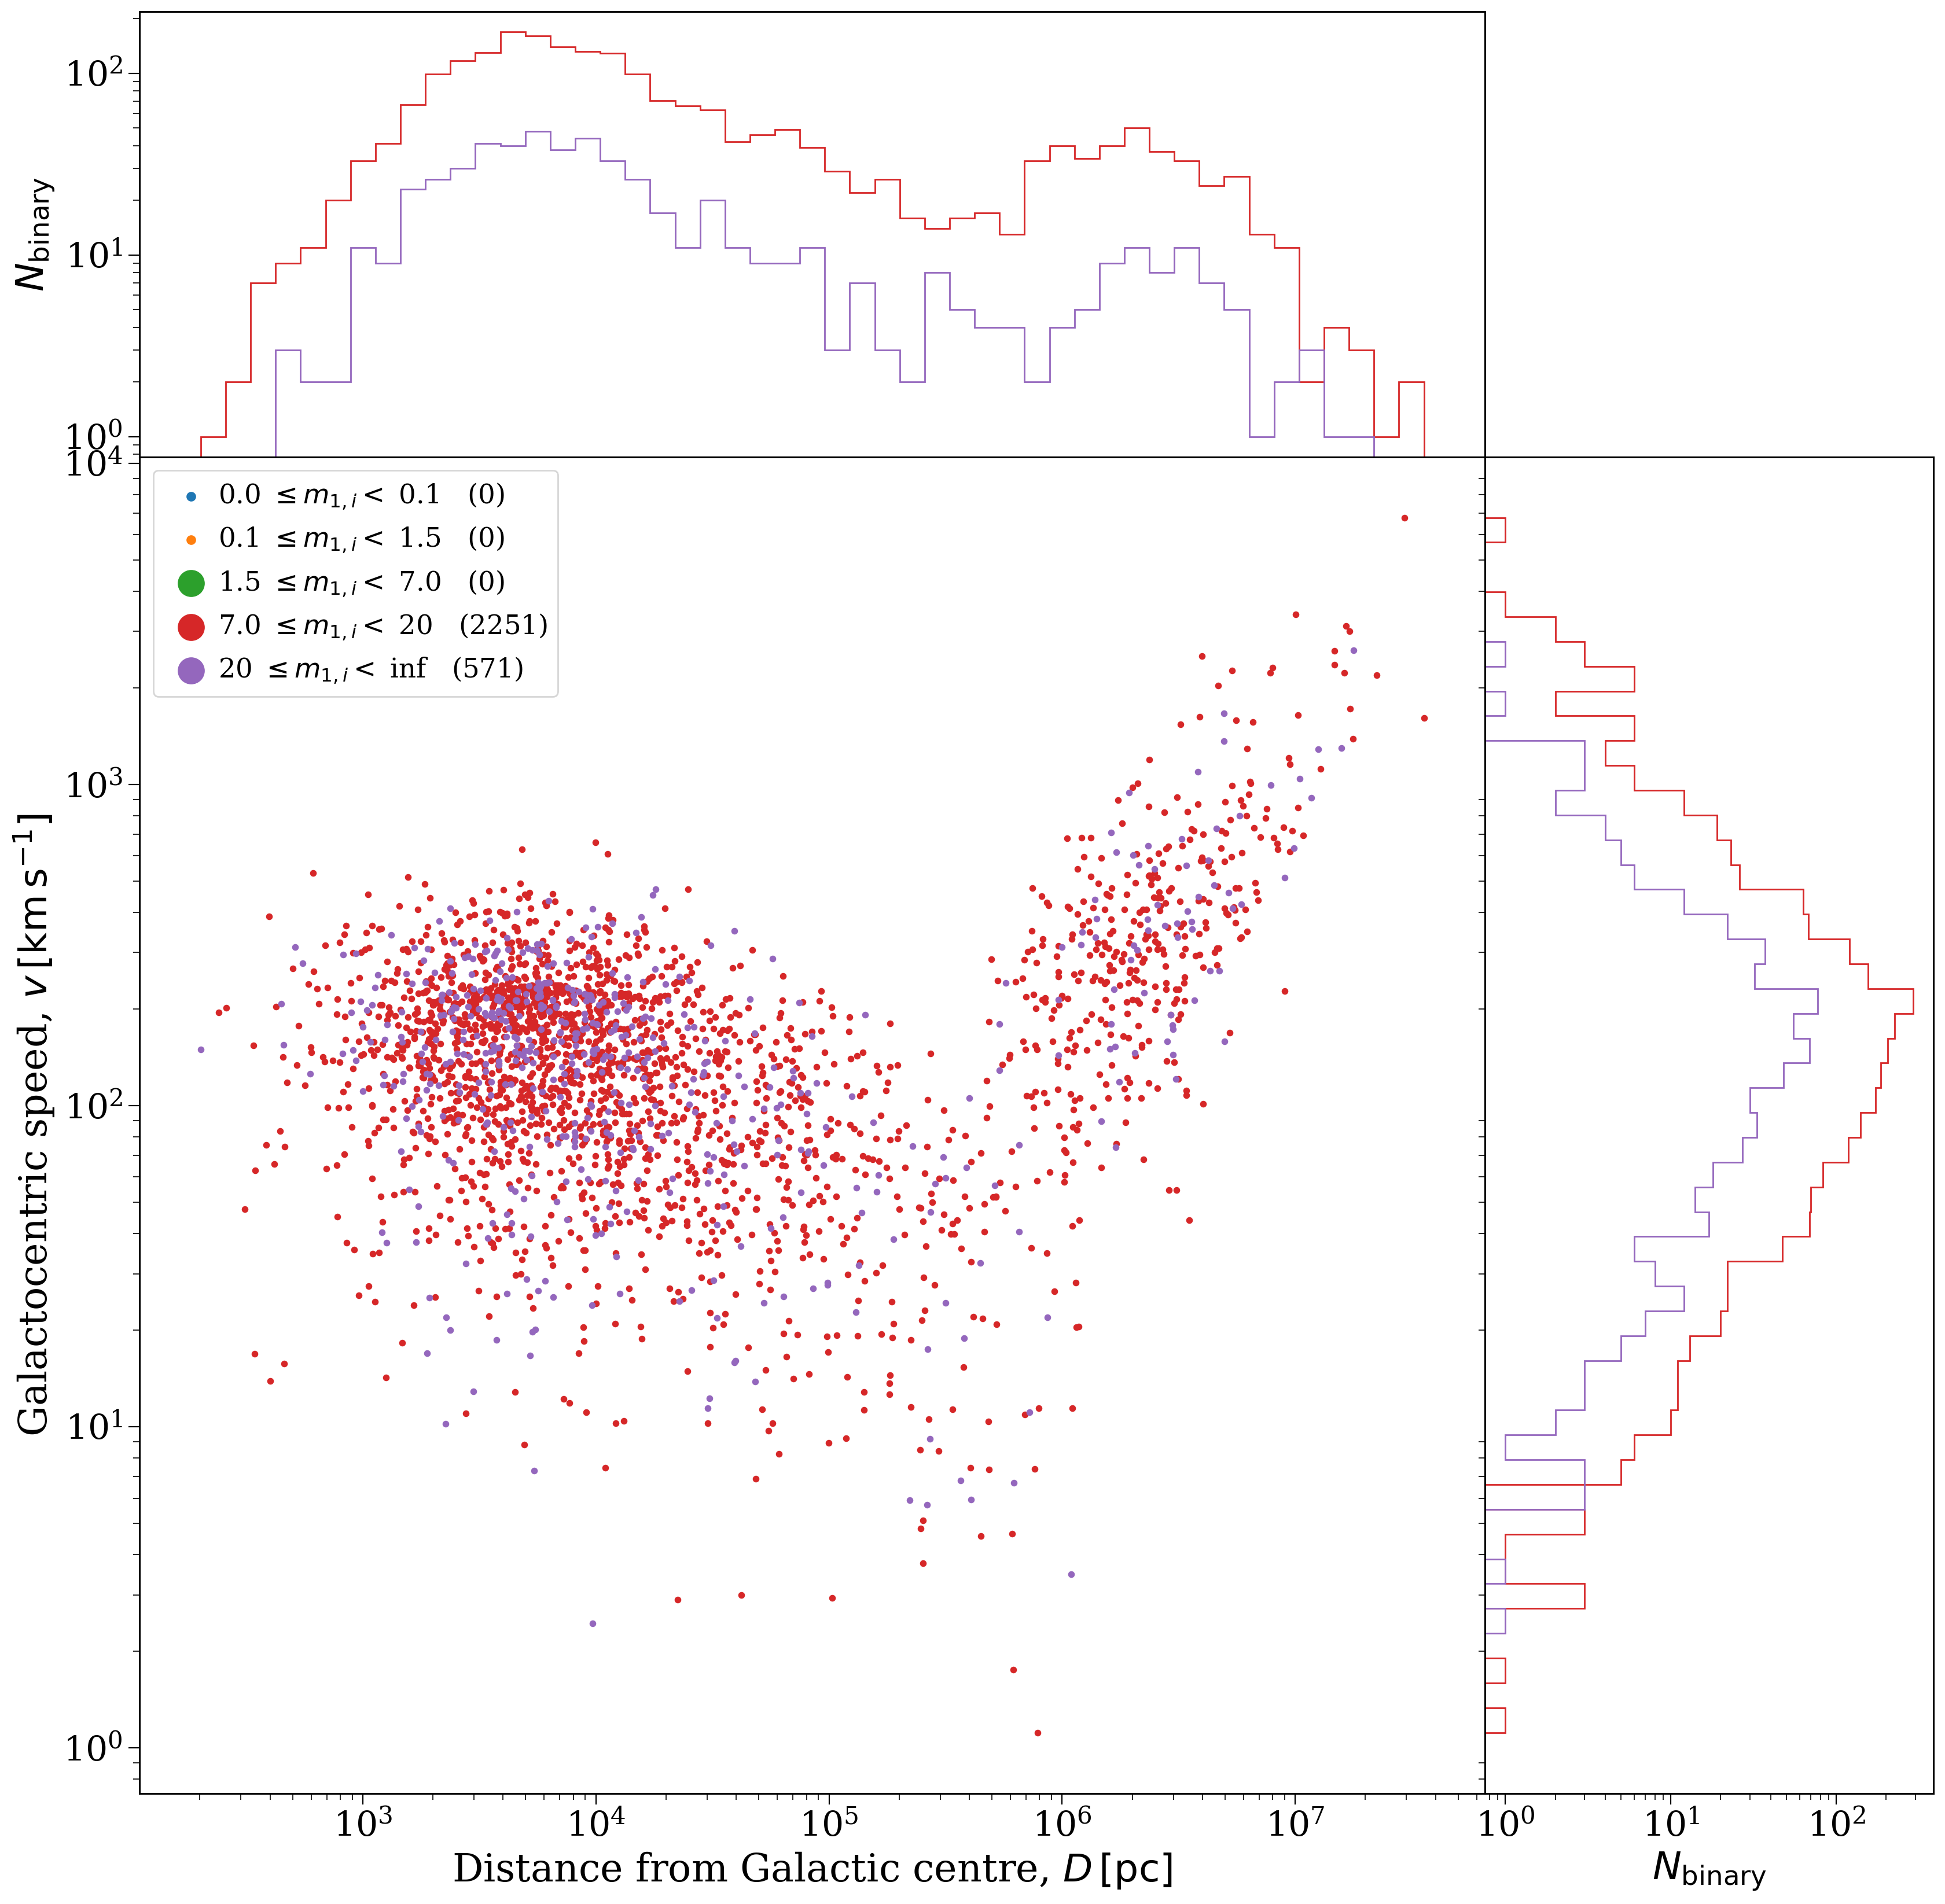

In [22]:
grid_plot_by_mass("dist", "speed", r"Distance from Galactic centre, $D\,[\rm pc]$", r"Galactocentric speed, $v\,[\rm km \, s^{-1}]$")

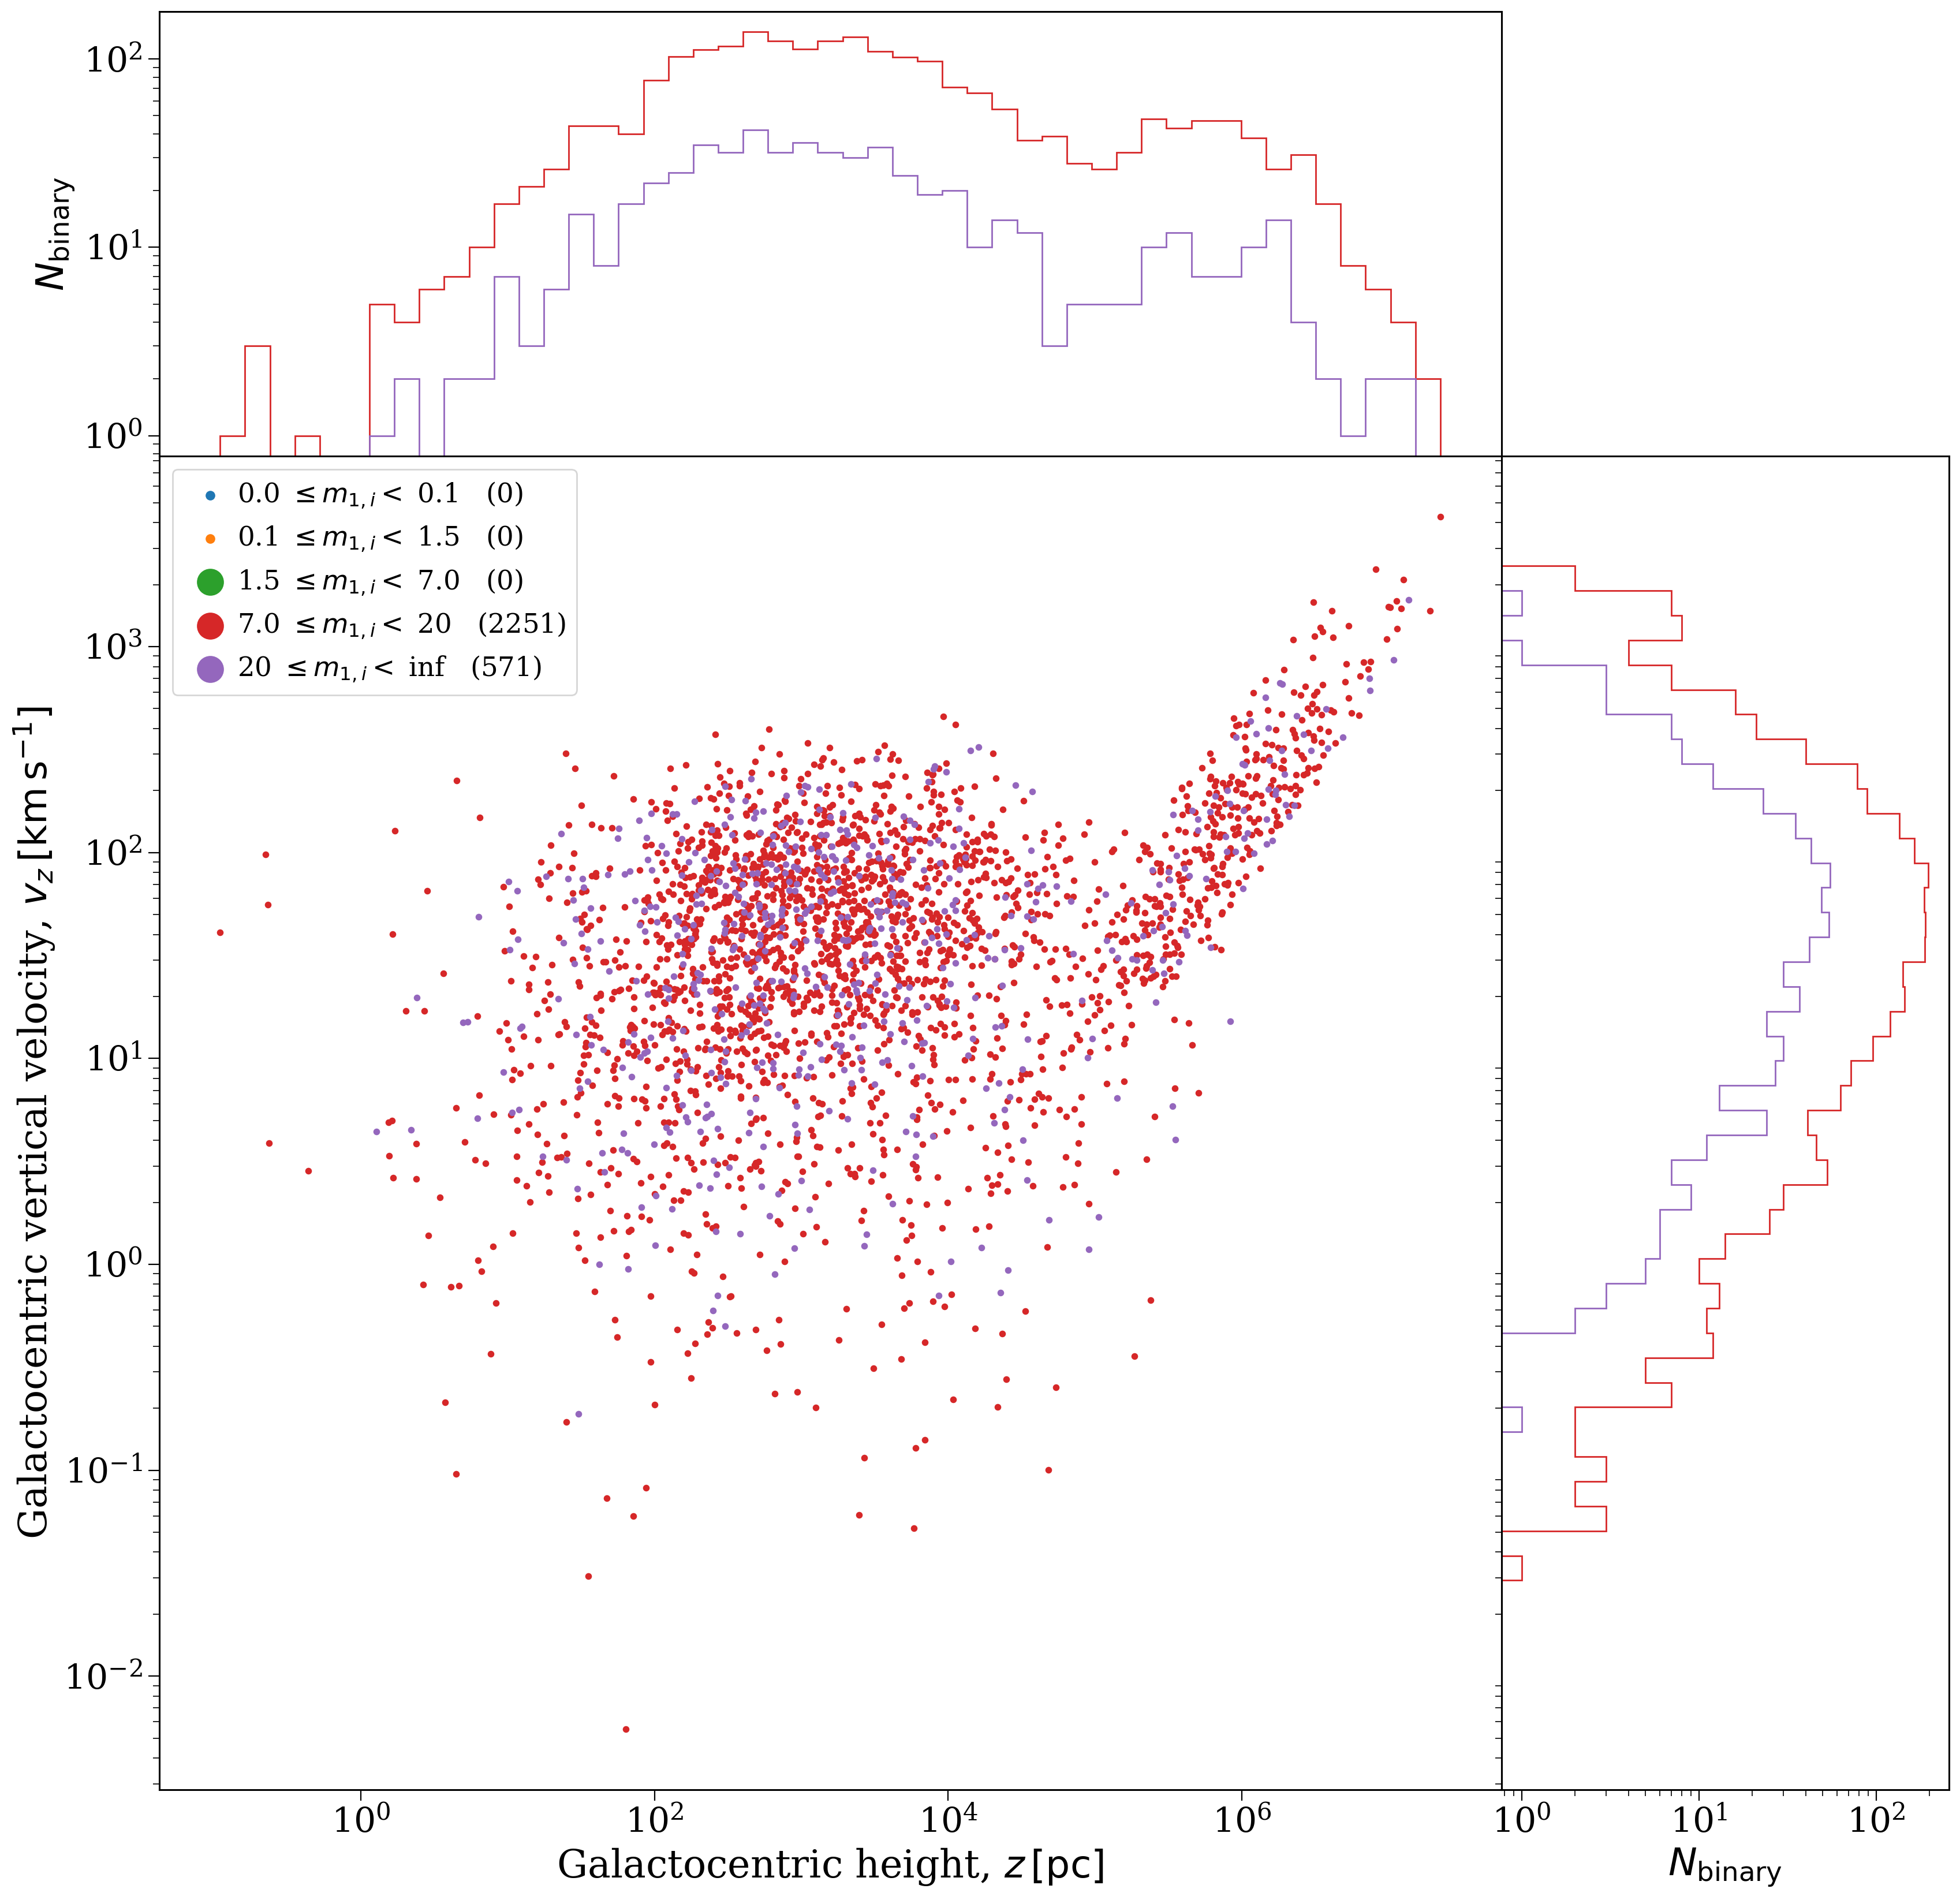

In [24]:
grid_plot_by_mass("z", "v_z", r"Galactocentric height, $z\,[\rm pc]$", r"Galactocentric vertical velocity, $v_z\,[\rm km \, s^{-1}]$")